# Άσκηση 3: Βελτιστοποίηση συναρτήσεων με Γενετικούς Αλγόριθμους
### Παπακωνσταντίνου Πολύβιος 03114892
### Πατρής Νικόλαος 03114861
##### Ομάδα Α30

<img src="http://infinity77.net/global_optimization/_images/Alpine01.png" alt="Alpine01" style="width: 500px;"/>

Στόχος της άσκησης είναι η βελτιστοποίηση συναρτήσεων χωρίς παραγώγους (derivative free optimization) με χρήση Γενετικών Αλγόριθμων μέσω της βιβλιοθήκης DEAP. Η βελτιστοποίηση χωρίς παραγώγους είναι ιδιαίτερα χρήσιμη σε περιπτώσεις όπου η αντικειμενική συνάρτηση $f$ δεν είναι διαθέσιμη (black-box optimization) ή σε περίπτωσεις που είναι, είναι δύσκολο ή μη πρακτικό να υπολογιστούν οι παράγωγοί της. Για παράδειγμα η  $f$ μπορεί να μην είναι διαφορίσιμη, η παραγώγιση της μπορεί να είναι δύσκολη ή να απαιτεί πολύ χρόνο,  η $f$ να περιέχει θόρυβο έτσι ώστε οι μέθοδοι που βασίζονται σε απειροστικές διαφορές να μην είναι αποτελεσματικές ή να υπάρχουν πολλά τοπικά βέλτιστα μεταξύ άλλων. 


### Βοηθητική συνάρτηση εκτύπωσης υπερπαραμέτρων και απόδοσης (σχετικής και απόλυτης)

Φτιάχνουμε τέλος μια βοηθητική συνάρτηση που τυπώνει συγκεντρωτικά τα αποτελέσματα ως εξής (η επεξήγηση για τις δύο πρώτες κολόνες στο ακριβώς επόμενο section):

| operators                      | strategy                      | successes | s.avg.min | s.avg.evals | s.avg.gens | avg.evals | avg.min   | avg.time |
|--------------------------------|-------------------------------|-----------|-----------|-------------|------------|-----------|-----------|----------|
|CrossoverLow,MutationLow,SelectionLow | eaSimple 200 0.8 0.2          | 1         | 8.508e-42 | 16487       | 96         | 17014     | 9.115e-34 | 1.898    |
| CrossoverHigh,MutationLow,SelectionLow | eaMuPlusLambda 50 150 0.8 0.2 | 1         | 3.885e-41 | 14750       | 98         | 15050     | 1.631e-21 | 1.591    

Ευτυχώς δεν χρειάστηκε να σκεφτούμε περίπλοκες υλοποιήσεις καθώς το DataFrame που παράγει η βιβλιοθήκη panda είναι ακριβώς αυτό που χρειαζόμαστε.

In [1]:
from deap import algorithms
from deap import base, creator, tools
import pandas as pd
import numpy 
import time
import itertools 

pd.set_option('display.max_colwidth', -1)

def report(data, columns_names=None):
    frame = pd.DataFrame(data, columns=columns_names)
    return frame

data = [['TestTestTest', 2], [3, "GGG"]]
report(data, ["Foo", "Bar"])

,Foo,Bar
0,TestTestTest,2
1,3,GGG



## Μέρος 1. Βελτιστοποίηση μη κλιμακούμενης συνάρτησης

Η μη-κλιμακούμενη συνάρτηση που αντιστοιχεί στον αριθμό της ομάδα μας είναι η  `Corana [37]`. Ύστερα απο συζήτηση που είχαμε με τον κύριο Σιόλα μας πρότεινε να χρησιμοποιήσουμε την συγκεκριμένη υλοποίηση, καθώς προβλέπει και για κάποιες ασάφειες που υπάρχουν στον 

In [3]:
import math as mt
 
def corana(x):
    # Credits: Giorgos Siolas
    # https://al-roomi.org/benchmarks/unconstrained/4-dimensions/90-corana-s-function
    # but also added check for z[i]!=0 from https://github.com/estsauver/yolo-nemesis/blob/master/coranaEval.m
    
    s=0.2
    d=[1,1000,10,100,10]
    z=[]
    sum=0
    for i in range(0, len(x)):
        z.append(0.2*mt.floor(mt.fabs(x[i]/s)+0.49999)*mt.copysign(1, x[i]))
        if mt.fabs(x[i]-z[i]) < 0.05 and z[i]!=0:
            sum = sum + 0.15*d[i]*(z[i]-0.05*mt.copysign(1, z[i]))**2
        else:
            sum = sum + d[i]*x[i]**2    
    return sum

In [4]:
corana([0,0,0,0])

0


### Εύρεση βέλτιστου συνδυασμού τελεστών - στρατηγικής



#### Γενετικοί τελεστές

Αρχικά θα δοκιμάσουμε δύο διαφορετικούς τελεστές διασταύρωσης και δύο διαφορετικούς τελεστές μετάλλαξης της επιλογής μας, με δύο διαφορετικές τιμές υπερ-παραμέτρων για τον καθένα. Θα δοκιμάσουμε επίσης δύο τιμές υπερ-παραμέτρων για τον τελεστή επιλογής selTournament. Έχουμε δηλαδή συνολικά 32 συνδυασμούς τελεστών. Σε αυτά αντιστοιχούν οι dummy ονομασίες της κολόνας "operators" (πλην του selTournament).

### Crossover

##### cxBlend

Ως πρώτο βήμα θα χρειαστεί να επιλέξουμε τους τελεστές διαστάυρωσης που θα χρησιμοποιήσουμε στον γενετικό μας αλγόριθμο. Οι τελεστές θα πρέπει να είναι σε θέση να διαχειρίζονται ίδιο τύπο αριθμών/γονιδίων ώστε να διασταυρώνουν σωστά τα χρωμοσώματα των ατόμων (individual). 

Εφόσον έχουμε πραγματικούς αριθμούς θα χρησιμοποιήσουμε αρχικά τον `cxBlend` που ανακατεύει το γενετικό υλικό των γονέων $x_1$ και $x_2$ σε κάθε διάσταση $i$ με τυχαίο τρόπο και ανάλογο της παραμέτρου $\alpha$: 

$\gamma = (1 + 2 \cdot \alpha) \cdot  random() - \alpha\\
ind1[i] = (1 - gamma) \cdot x_1[i] + gamma \cdot x_2[i]\\
ind2[i] = gamma \cdot x_1[i] + (1 - gamma) \cdot x_2[i]$

Οι τιμές που θα δοκιμάσουμε για την υπερπαράμετρο `alpha` θα πρέπει να είναι ο συνδυασμός μιας υψηλής που θα οδηγεί σε μεγαλύτερη μεταβολή του γενετικού υλικού και μιας μικρή για τον προφανή λόγο. Μπορούμε να κατασκευάσουμε μία συνάρτηση για να παρατηρήσουμε τις μεταβολές που επιβάλλει στην `gamma` η υπερπαράμετρος `alpha`. Θα τρέξουμε ένα αριθμό γύρων και θα δοκιμάζουμε 50 τιμές στο διάστημα 1-20. Μετά την ολοκλήρωση των γύρων θα υπολογίσουμε την μέση τιμή της `gamma` για κάθε μία απο τις 50 τιμές. Δυστυχώς δεν μπορούμε να προβλέψουμε την τιμή της `gamma` στο διάστημα 0-1, ώστε να καθορίσουμε ποιου ατόμου το χρωμόσωμα θα κυριαρχήσει.

In [5]:
import random
import numpy as np

gamma = lambda alpha: (1+2*alpha) * random.random() - alpha

def gamma_mean(low=1, high=20, num=50, rounds=100):
    alpha_values = np.linspace(low, high, num)

    gamma_mean = []
    for i in range(rounds):
        gammas = [gamma(j) for j in alpha_values]
        gamma_mean.append(gammas)

    return alpha_values, np.mean(gamma_mean,0)

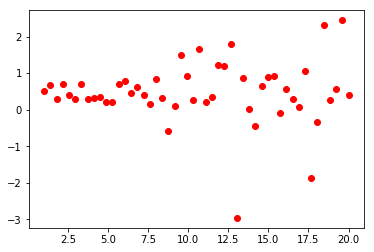

In [7]:
import matplotlib.pyplot as plt

alphas, gammas = gamma_mean()

plt.plot(alphas, gammas, 'ro')
plt.show()

Παρατηρούμε ότι με τιμές κοντά στο 1, η υπεπαράμετρος `alpha` 
αναμειγνύει καλύτερα τα γονίδια των δύο ατόμων καθώς φαίνεται να ισομοιράζει τις τιμές σε κάθε θέση $(gamma \sim 0.5)$. Όσο οι τιμές μεγαλώνουν και η `gamma` ξεπερνά το 1, δηλαδή η `alpha` γίνεται μεγαλύτερη απο το 5, οι αλλαγές στα γονίδια γίνονται όλο και πιο έντονες. Ως εκ τούτου οι δύο τιμές που θα επιλέξουμε θα είναι: $1,5$.

##### cxSimulatedBinary

O δεύτερος τελεστής που επιλέξαμε θα είναι ο `cxSimulatedBinary`. Όπως και με τον προηγούμενο, δέχεται μία υπεπαράμετρο, την `eta`. Η παράμετρος αυτή επηρεάζει της διαδικασία της διαστάυρωσης των γονιδίων με τον εξής τρόπο.

```python
if rand <= 0.5:
    beta = 2. * rand
else:
    beta = 1. / (2. * (1. - rand))
beta **= 1. / (eta + 1.)

ind1[i]=0.5*(((1 + beta) * x1) + ((1 - beta) * x2))
ind2[i]=0.5*(((1 - beta) * x1) + ((1 + beta) * x2))
```

Θα ακολουθήσουμε παρόμοια διαδικασία με το προηγούμενο ώστε να ανιχνεύσουμε τις μεταβολές της `eta` στα γονίδια των ατόμων. Η μεταβλητή που ευθύνεται για τις μεταβολές είναι η `beta`, για αυτό το λόγο θα είναι και αυτή που θα οπτικοποιήσουμε.

In [8]:
import random
import numpy as np

def beta(eta):
    rand = random.random()
    if rand <= 0.5:
        beta = 2. * rand
    else:
        beta = 1. / (2. * (1. - rand))
    beta **= 1. / (eta + 1.)
    
    return beta

def beta_mean(low=1, high= 50, num=50, rounds=100):
    eta_values = np.linspace(low, high, num)

    beta_mean = []
    for i in range(rounds):
        betas = [beta(j) for j in eta_values]
        beta_mean.append(betas)

    return eta_values, np.mean(beta_mean,0)

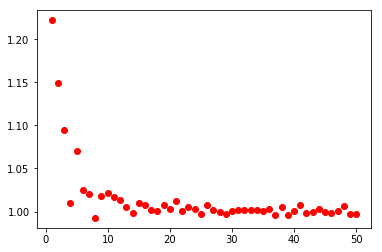

In [9]:
import matplotlib.pyplot as plt

etas, betas = beta_mean()

plt.plot(etas, betas, 'ro')
plt.show()

Όπως παρατηρούμε καθώς η τιμή της `eta` μεγαλώνει η τιμή της `beta` συγκλίνει στο 1, δημιουργώντας μια στατική διασταύρωση (stationary crossover) των γονιδίων, με αποτέλεσμα οι τιμές των παδιών να μην αποκλίνουν με τις τιμές των γονέων. Εμείς ενδιαφερόμαστε για τιμές της `eta` που δημιουργούν contracting ή expanding crossovers. Για αυτό θα περιορίσουμε το εύρος αναζήτησης στο διάστημα 0-1.

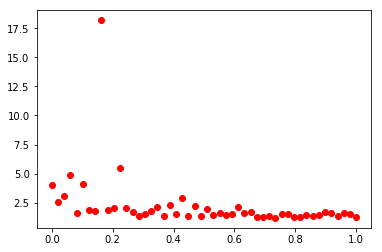

In [10]:
etas, betas = beta_mean(low=0, high=1)

plt.plot(etas, betas, 'ro')
plt.show()

Όσο πιο μικρή τιμή δίνουμε στην υπεπαράμετρο `eta` τόσο μεγαλύτερη αλλαγή δημιουργεί στο γενετικό υλικό των ατόμων. Σύμφωνα λοιπόν με τα παραπάνω δύο αντιπροσεπευτικές τιμές είναι: $0.2, 0.8$

### Mutation

Αφού λοιπόν ολοκληρώσαμε το πρώτο βήμα της επιλογής των τελεστών διασταύρωσης, περνάμε στο δεύτερο που είναι η επιλογή τελεστών μετάλλαξης μαζί με τις δύο ακραίες τιμές (high, low) των υπερπαραμέτρων τους.

#### mutGaussian

Έχοντας πλέον εξοικειωθεί με την γκαουσιανή μετάλλαξη ήδη από τα εργαστήρια και γνωρίζοντας βεβαίως την λειτουργικότητας με floating αριθμούς θα είναι η πρώτη μας επιλογή ως τελεστή. Η συνάρτηση αυτή χαρακτηρίζεται από ένα ζεύγος υπερπαραμέτρων: της μέσης τιμής και της διασποράς, οι οποίες λειτουργούν με τον εξής τρόπο.

```python
individual[i] += random.gauss(m, s)
```
Η παραπάνω εντολή είναι εκείνη που περιγράφει την λειτουργία του συγκεκριμένου τελεστή μετάλλαξης, προσθέτει απλά γκαουσιανό θόρυβο σε κάθε γονίδιο του ατόμου. Είναι προφανές λοιπόν ότι η υπερπαράμετρος που καθορίζει την επίδραση που θα έχει η μετάλλαξη σε κάθε άτομο είναι κυρίως η μέση τιμή, καθώς αν επιλέξουμε μία μικρή τιμή για την διασπορά ο θόρυβος που θα προστίθεται θα έχει τιμές κοντά στην μέση τιμή. Δύο καλές τιμές θα ήταν $(0,1), (20,10)$. Η τιμή της `indpb`, δηλαδή της πιθανότητας να τροποποιηθεί κάθε γονίδιο του χρωμοσώματος θα την έχουμε σταθερή στο 0.5, ώστε να μην μεροληπτούμε υπέρ ή κατά της μετάλλαξης.

#### mutPolynomialBounded

Η δεύτερη επιλογή μας για τελεστή μετάλλαξης είναι μονόδρομος \*\*. Δυστυχώς λόγω του περιορισμένου αριθμού των τελεστών μετάλλαξης, ο μόνος εκτός του `mutGaussian` που επιτρέπεται για την χρήση `float` αριθμών είναι ο `mutPolynomialBounded`. Οι υπερπαράμετροι που χρησιμοποιεί ο τελεστής είναι οι εξής: $eta, low, up, indp$. Ήδη από όσα έχουμε ήδη περιγράψει η πρώτη και η τελευταία παράμετρος έχει αναλυθεί αρκετά ως προς τον τρόπο λειτουργίας της καθώς και για την επίδραση που έχει στα "γεννετικό υλικό" των ατόμων. Η υλοποίηση του συγκεκριμένου μηχανισμού παρούσιαζεται παρακάτω. Ο λόγος για την επιλογή μας, όπως και με τα προηγούμενα, είναι ότι θα μας βοηθήσει αρκετά στην επεξέγηση και στην αιτιολόγηση των επιλογών μας.

```python
if random.random() <= indpb:
    x = individual[i]
    delta_1 = (x - xl) / (xu - xl)
    delta_2 = (xu - x) / (xu - xl)
    rand = random.random()
    mut_pow = 1.0 / (eta + 1.)

    if rand < 0.5:
        xy = 1.0 - delta_1
        val = 2.0 * rand + (1.0 - 2.0 * rand) * xy**(eta + 1)
        delta_q = val**mut_pow - 1.0
    else:
        xy = 1.0 - delta_2
        val = 2.0 * (1.0 - rand) + 2.0 * (rand - 0.5) * xy**(eta + 1)
        delta_q = 1.0 - val**mut_pow

    x = x + delta_q * (xu - xl)
    x = min(max(x, xl), xu)
    individual[i] = x
```

Αμέσως λοιπόν μπορούμε να παρατηρήσουμε την επίδραση μια αρκετά μεγάλης τιμής για την παράμετρο `eta`. Η τοπική μετάβλητη `mut_pow` συγκλίνει προς το μηδέν καθώς η τιμής της `eta` μεγαλώνει παράλληλα με την `delta_q`: 
$$delta\_q = (1-val^{mut\_pow}) \Rightarrow^{\{mut\_pow \rightarrow 0\}}= (1-val^0) = 1-1=0$$. 
Παρόμοια συμπεριφορά εμφανίζει και όταν τα `low`,`up` είναι αρκετά κοντά, καθώς τείνει να μηδενιστεί. Στην αντίθετη περίπτωση όπου οι δύο προηγούμενες παράμετροι αποκτούν μεγάλη απόκλιση μεταξύ τους η τροποποιήση που υφίσταται το κάθε γονίδιο είναι αρκετά μεγάλη. Αφού λοιπόν κατάφεραμε να ερμηνεύσουμε την επίδραση των παραμέτρων το μόνο που μένει είναι να βρούμε δύο αντιπροσωπευτικές τιμές. 

Ωστόσο υπάρχει ένα σημαντικό σημείο που πρέπει να προσέξουμε. Επειδή η `mut_pow` είναι πάντα μικρότερη του 1, ενδέχεται όταν την χρησιμοποιήσουμε για να υψώσουμε κάτι σε δύναμη (π.χ. την `val`) να προκύξει μιγαδικός αριθμός. Θα πρέπει επομένως να κρατήσουμε την `val` θετική. Ένας εύκολος τρόπος θα ήταν να κρατήσουμε τις μεταβλητές `delta_1, delta_2` θετικές (θα είναι επίσης και $<1$). Θα μπορούσαμε να θέσουμε τις τιμές των `low`, `high` τέτοιες ώστε να σχηματίζουν ένα διάστημα που περιλάμβανει τα τις επιτρεπές τιμές για τα γονίδια (-100,100). Θα παρατηρήσουμε όμως ότι δεν μπορούμε να είμαστε σίγουροι για τις νέες τιμές που θα προκύψουν απο τα στάδιο της διαστάυρωσης, με αποτέλεσμα να εμφανιστεί και πάλι αρνητικό υπόρριζο. Η **μόνη λύση** θα είναι να κατασκευάσουμε τον ίδιο τελεστή μετάλλαξης και στην περίπτωση που η `delta_q` είναι μιγαδικός αριθμός να χρησιμοποιούμε μόνο το πραγματικό μέρος του.

\*\* Παραμένει μόνο η `mutShuffleIndexes()` αλλά δεν μας καλύπτει ένα απλό μπέρδεμα το indices ως προς το κομμάτι της μετάλλαξης.

In [11]:
def mutPolynomialBounded(individual, eta, low, up, indpb):
    size = len(individual)
    low = [low] * size
    up = [up] * size

    for i, xl, xu in zip(range(size), low, up):
        x = individual[i]
        delta_1 = (x - xl) / (xu - xl)
        delta_2 = (xu - x) / (xu - xl)
        rand = random.random()
        mut_pow = 1.0 / (eta + 1.)

        if rand < 0.5:
            xy = 1.0 - delta_1
            val = 2.0 * rand + (1.0 - 2.0 * rand) * xy**(eta + 1)
            delta_q = val**mut_pow - 1.0
        else:
            xy = 1.0 - delta_2
            val = 2.0 * (1.0 - rand) + 2.0 * (rand - 0.5) * xy**(eta + 1)
            delta_q = 1.0 - val**mut_pow

        if isinstance(delta_q, (complex)):
            delta_q = delta_q.real

        x = x + delta_q * (xu - xl)
        x = min(max(x, xl), xu)
        individual[i] = x

    return individual,

Σύμφωνα με όσα είπαμε μια επιλογή για την `eta`θα ήταν λίγο μεγαλύτερη απο το 1, ώστε η επίδραση να μην είναι καταλυτική για τις νέες τιμές των γονιδίων. Η `inpd` θα μείνει και πάλι στο $0.5$ για τον ίδιο λόγο με τον προήγουμενο τελεστή μετάλλαξης, ενώ όσο για το `low`, `up` οι τιμές τους θα είναι αυτές που θα καθορίσουν την χαμηλή και υψηλή επίδραση που ζητείται στην εκφώνηση.

- eta = 0.2, low=-5, up=5, indpb=0.5
- eta = 0.002, low=-100, up=100, indpb=0.5

### Selection

#### selTournament

Ο τελευταίος τελεστής υλοποιεί την διαδικάσια της φυσικής επιλογής του γενετικού αλγόριθμου. Παρόλο που στο **documentaion** φαίνεται να μπορούμε να ορίσουμε και δεύτερη παράμετρο εκτός απο το `tournsize`. H υλοποίηση όμως των στρατηγικών της εξέλιξης έχουν θέσει apriori την τιμή της `k` να είναι ίση με το μέγεθος του πληθυσμού. 

```python
--eaSimple--
offspring = toolbox.select(population, len(population))
------------
```

```python
def selTournament(individuals, k, tournsize, fit_attr="fitness"):
    chosen = []
    for i in xrange(k):
        aspirants = selRandom(individuals, tournsize)
        chosen.append(max(aspirants, key=attrgetter(fit_attr)))
    return chosen
```

Επομένως επιλέγονται κάθε φορά $k = len(population)$ άτομα μέσω της `selRandom`, η οποία διαλέγει τυχαία `tournsize` άτομα από τα οποία η `selTournament` επιλέγει αυτό με την μεγαλύτερη `fit_attr` τιμή. Αν λοιπόν μεγαλώσουμε ή μικρύνουμε αρκετά την τιμή του `tournsize` ενδεχομένως να χρειαστούν αρκετές γενιές για να βρεθεί η λύση. Σύμφωνα με όσα αναφέραμε οι δύο τιμές που θα επιλέξουμε για την υπεπαράμετρο `tournsize` είναι: $5,30$.




#### Στρατηγική εξέλιξης

Για κάθε συνδυασμό τελεστών θα εξετάσουμε τρεις στρατηγικές: τον **απλό ΓΑ** και τις στρατηγικές εξέλιξης **“μ+λ”** και **“μ,λ”**. Στην κολόνα strategy βλέπετε το όνομα της στρατηγικής και μετά την τιμή ή τις τιμές που χαρακτηρίζουν τον πληθυσμό. Προφανώς o απλός γενετικός έχει μόνο το μέγεθος του πληθυσμού ενώ οι δύο άλλες στρατηγικές έχουν τις τιμές για τα μ και λ. Οι δύο τελευταίοι αριθμοί της κολόνας αντιστοιχούν στις πιθανότητες διασταύρωσης και μετάλλαξης.



#### Μεθοδολογία εύρεσης βέλτιστου συνδυασμού

Αρχικά θα προσδιορίσουμε τους καταλληλότερους συνδυασμούς τελεστών-στρατηγικών. Για το λόγο αυτό θα θέσουμε ένα σχετικά μικρό αριθμό γύρων (π.χ. 5-10) και μέγιστων γενεών (π.χ. 50-100-150) και σταθερές τιμές στις παραμέτρους πληθυσμού και τις πιθανότητες διασταύρωσης και μετάλλαξης. 

Θα διαλέξουμε ένα αρχικό `delta` κοντά στο ολικό ελάχιστο του καλύτερου συνδυασμού (από τα πρώτα runs που θα κάνετε). Το “κοντά” σε αυτό το στάδιο μπορούμε να το εκτιμήσουμε μόνο εμπειρικά, επαναλαμβάνοντας με διάφορα `delta` έτσι ώστε στην τελική επιλογή `delta` οι καλύτεροι συνδυασμοί να έχουν ποσοστό επιτυχιών κοντά στη μονάδα και οι χειρότεροι καμία. 

----

Επειδή η όλη διαδικασία της εύρεσης του βέλτιστου συνδυασμού απαιτεί ένα είδος εξαντλητικής αναζήτησης, αφού συνολικά θα χρειαστεί να τρέξουμε $96 * maxrounds$ γενετικούς αλγόριθμους, δημιουργήσαμε μια κύρια wrapper συνάρτηση η οποία δέχεται όλες τις απαραίτητες παραμέτρους για την εκτέλεση τόσο των στρατηγικών εξέλιξης όσο και για κάποιες επιπλέον συναρτήσεις που θα αναφέρουμε στην συνέχεια. 

In [480]:
def evolution_with_stats(ge_with_stats, npop, toolbox, mu, lambda_, ngen, cxpb, mutpb, rounds, goal, delta, verbose=False):
    MAX_ROUNDS = rounds

    # Absolute Criteria
    avg_min = []
    avg_evals = []
    avg_time = []
    
    # Relevant Criteria
    successes = []
    s_avg_gens = []
    s_avg_min = []
    s_avg_evals = []
    
    for i in range(MAX_ROUNDS):
        if not gstrategy_name(ge_with_stats) == "eaSimple":
            args = {"mu" : mu, "lambda_" : lambda_}
        else:
            args = {}
        
        # Start Stopwatch
        stopwatch = alarm()
        pop, log = ge_with_stats(npop=npop, toolbox=toolbox, ngen=ngen, cxpb=cxpb, mutpb=mutpb, **args)
        avg_time.append(alarm(stopwatch))
        # Stop Stopwatch
        
        # Absolute Criteria
        min_fit, nevals = abs_crit(pop, log)
        avg_min.append(min_fit)
        avg_evals.append(nevals)  
        
        #Relevant Criteria
        success, s_gens, s_min, s_evals = rel_crit(log, goal, delta)
        if success:
            successes.append(success)
            s_avg_gens.append(s_gens)
            s_avg_min.append(s_min)
            s_avg_evals.append(s_evals)
        
        if verbose:
            flag = "Sucess" if success else "Failure"
            print("[Round #{0}] {1}".format(i, flag), success, s_gens, s_min, s_evals)
    
    # Absolute Criteria
    avg_time = np.mean(avg_time)
    avg_evals = np.mean(avg_evals)
    avg_min = np.mean(avg_min)
    
    # Relevant Criteria
    if successes:
        successes = np.sum(successes)
        s_avg_gens = np.mean(s_avg_gens)
        s_avg_min = np.mean(s_avg_min)
        s_avg_evals = np.mean(s_avg_evals)
    else:
        successes = 0
        s_avg_gens = None
        s_avg_min = None
        s_avg_evals = None
        
    return successes, s_avg_min, s_avg_evals, s_avg_gens, avg_evals, avg_min, avg_time


Για να αποφύγουμε να μεγαλώσουμε αρκετά το μέγεθος της συνάρτησης, φτιάξαμε τις εξής βοηθητικές συναρτήσεις:
- alarm(): Μετράει τον χρόνο που χρειάζεται για να τρέξει ο γενετικός αλγόριθμος
- abs_crit: Επιστρέφει τις τιμές των απόλυτων κριτηρίων για κάθε γύρο
- rel_crit: Επιστρέφει τις τιμές των σχετικών κριτηρίων για κάθε γύρο

Αφού λοιπόν ολοκληρωθούν όλοι οι γύροι υπολογίζουμε και επιστρέφουμε τα τελικά μεγέθη.

```python
avg_min, avg_evals, avg_time, successes, success_avg_gen, success_avg_min, success_avg_evals
```

In [13]:
def alarm(prev_time=None):
    if not prev_time:
        return time.time()
    else:
        return (time.time()-prev_time)

In [14]:
def abs_crit(pop, log):
    min_fit = get_min_fit(pop)
    nevals = log.select("nevals")
    
    return min_fit, np.sum(nevals)

def get_min_fit(pop):
    (best_ind, ) = tools.selBest(pop, k=1)
    (min_fit, ) = best_ind.fitness.values
    
    return min_fit

In [15]:
def rel_crit(logbook, goal, delta):
    success = None
    success_gen = None
    success_min = None
    success_evals = None
    
    evals_cnt = 0
    for gen, log in enumerate(logbook):
        evals_cnt += log["nevals"]
        
        if log["min"] <= (goal + delta):
            success = 1
            success_gen = gen
            success_min = log["min"]
            success_evals = evals_cnt
            
            break
    return (success, success_gen, success_min, success_evals)

Το πρώτο μας βήμα θα είναι να κατασκευάσουμε τα `containers` που θα περιγράφουν τις οντότητες/άτομα και τον πληθυσμό. Το `toolbox` θα  τροποποιείται κάθε φορά ώστε να αντιστοιχεί στον συνδυασμό των τελεστών και της στρατηγικής εξέλιξης που θέλουμε να εξετάσουμε κάθε φορά. Η μόνη εγγραφή που θα μείνει ανεπηρέαστη σε όλους τους συνδυασμούς είναι η `evaluate`, που απλά υπολογίζει την τιμή της συνάρτησης που θέλουμε να ελαχιστοποιήσουμε. 

Επιλέξαμε να μην αναλύσουμε περαιτέρω τις βασικές εντολές κατασκευής των δομών καθώς πιστεύουμε ότι θεωρούνται ήδη γνωστές απο το εργαστήριο.

In [16]:
NUM_VARS = 4

creator.create( "min_fitness", base.Fitness , weights=(-1.0,))
creator.create( "individual_container", list , fitness= creator.min_fitness)
toolbox = base.Toolbox()
toolbox.register("init_value", np.random.uniform, -100, 100)
toolbox.register("individual", tools.initRepeat, creator.individual_container, toolbox.init_value, NUM_VARS)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def eval_corana(ind):
    sum = corana(ind)
    
    return (sum,)

toolbox.register("evaluate", eval_corana)

Στην συνέχεια θα ορίσουμε τα ορίσματα που θα χρειαστεί να δόσουμε στους τελεστές μετάλλαξης ώστε στην συνέχεια να τα εγγράψουμε στο `toolbox` του γενετικού αλγόριθμου. Ευτυχώς η Python μας παρέχει έναν πολύ εύκολο τρόπο να περνάμε τα ορίσματα μέσω ενός λεξικού, χωρίς να χρειάζεται να γράφουμε ένα-ένα τα ονόματα των μεταβλητών στην συνάρτηση που θέλουμε να εκτελέσουμε. Τα ορίσματα αυτά λέγονται `kargs` (keyword-arguments)

------
Στα τρία παρακάτω κελιά φαίνονται όλοι οι συνδυασμοί τιμών που θέλουμε να παράξουμε με τις υπεπαραμέτρους των γενετικών τελεστών. Έχουμε διαμορφώσει τα ορίσματα σε μορφή λεξικού και έχουμε γράψει βοηθητικές συναρτήσεις για την παραγωγή των `k[eyword]arg[ument]s`.

##### Crossover/Mate Combinations

In [17]:
kargs_cxBlend = {
    "function" : tools.cxBlend,
    "args" : {
        "alpha" : [1,5]
    }
}

kargs_cxSimulatedBinary = {
    "function" : tools.cxSimulatedBinary,
    "args" : {
        "eta" : [0.2, 0.8]
    }
}

mate_ops = [kargs_cxBlend, kargs_cxSimulatedBinary]

def args_product(d):
    keys = d.keys()
    for element in itertools.product(*d.values()):
        yield dict(zip(keys, element))

for mate in mate_ops:
    function = mate["function"]
    for mate_flag, args in enumerate(args_product(mate["args"])):
        toolbox.register("mate", function=function, **args)
        print(mate_flag, toolbox.mate)

0 functools.partial(<function cxBlend at 0x10f1c80d0>, alpha=1)
1 functools.partial(<function cxBlend at 0x10f1c80d0>, alpha=5)
0 functools.partial(<function cxSimulatedBinary at 0x10f1c8158>, eta=0.2)
1 functools.partial(<function cxSimulatedBinary at 0x10f1c8158>, eta=0.8)


##### Mutation Combinations

In [18]:
kargs_mutGaussian = {
    "function" : tools.mutGaussian,
    "args" : {
        "mu" : [0,20],
        "sigma" : [1,10],
        "indpb" : [0.5, 0.5]
    }
}

kargs_mutPolynomialBounded = {
    "function" : mutPolynomialBounded,
    "args" : {
        "eta" : [0.2, 0.2],
        "low" : [-5, -100],
        "up" : [5, 100],
        "indpb" : [0.5, 0.5]
    } 
}

mutation_ops = [kargs_mutGaussian, kargs_mutPolynomialBounded]

def args_perm(d):
    keys = d.keys()
    fillvalue = d["indpb"][0] if "indpb" in d else None
    for element in itertools.zip_longest(*d.values(), fillvalue=fillvalue):
        yield dict(zip(keys, element))

for mutation in mutation_ops:
    function = mutation["function"]
    for mutation_flag, args in enumerate(args_perm(mutation["args"])):
        toolbox.register("mutation", function=function, **args)
        print(mutation_flag, toolbox.mutation)

0 functools.partial(<function mutGaussian at 0x1158e6510>, mu=0, sigma=1, indpb=0.5)
1 functools.partial(<function mutGaussian at 0x1158e6510>, mu=20, sigma=10, indpb=0.5)
0 functools.partial(<function mutPolynomialBounded at 0x118154158>, eta=0.2, low=-5, up=5, indpb=0.5)
1 functools.partial(<function mutPolynomialBounded at 0x118154158>, eta=0.2, low=-100, up=100, indpb=0.5)


##### Selection Combinations

In [19]:
kargs_selTournament = {
    "function" : tools.selTournament,
    "args" : {
        "tournsize" : [5, 30]
    }
}

selection_ops = [kargs_selTournament]

for selection in selection_ops:
    function = selection["function"]
    
    for selection_flag, args in enumerate(args_product(selection["args"])):
        toolbox.register("select", function=function, **args)
        print(selection_flag, toolbox.select)

0 functools.partial(<function selTournament at 0x1158e6ae8>, tournsize=5)
1 functools.partial(<function selTournament at 0x1158e6ae8>, tournsize=30)


#####  Evolution Strategy Wrappers

Αφού λοιπόν καταφέραμε να παράξουμε τους συνδυασμούς των γενετικών τελεστών θα γράψουμε τους επόμενους 3 wrapper για τις στρατηγικές εξέλιξης που μας ζητείται να δοκιμάσουμε. Ο πληθυσμός καθώς και οι πιθανότητες μετάλλαξης και διαστάυρωσης είναι ίδιες και για τους 3 γενετικούς αλγόριθμους. Στην περίπτωση των `eaMuPlusLambda, eaMuCommaLambda` έχουμε δύο ακόμα υπεπαραμέτρους τα `mu,lambda_`, οι οποίες ειναι ίδιες και για τους δύο αλγόριθμους.

In [477]:
def eaSimple_with_stats(npop, toolbox, cxpb, mutpb, ngen):
    pop = toolbox.population(n=npop)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", numpy.min)
    
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=ngen, stats=stats, verbose=False)

    return pop, log


In [478]:
def eaMuPlusLambda_with_stats(npop, toolbox, mu, lambda_, cxpb, mutpb, ngen):
    pop = toolbox.population(n=npop)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", numpy.min)
    
    pop, log = algorithms.eaMuPlusLambda(pop, toolbox, mu=mu , lambda_=lambda_ , cxpb=cxpb, mutpb=mutpb, ngen=ngen, stats=stats, verbose=False)

    return pop, log

In [479]:
def eaMuCommaLambda_with_stats(npop, toolbox, mu, lambda_, cxpb, mutpb, ngen):
    pop = toolbox.population(n=npop)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", numpy.min)
    
    pop, log = algorithms.eaMuCommaLambda(pop, toolbox, mu=mu , lambda_=lambda_ , cxpb=cxpb, mutpb=mutpb, ngen=ngen, stats=stats, verbose=False)

    return pop, log

Περνάμε πλέον στο τελικό στάδιο όπου όλα τα επιμέρους κομμάτια πρέπει να ενωθούν για να δημιουργήσουν την τελική συνάρτηση εύρεσης του βέλτιστου συνδυασμού. Αν παρατηρήσατε προηγουμένως έχουμε σκοπίμα γράψει τους βρόγχους για την παραγωγή των συνδυασμών των τελεστών, μάζι την αρίθμηση τους (0,1). Το `0` θα αντιστοιχεί στην "Low" επιλογή, ενω το `1` στην "High". Επίσης γράψαμε δύο βοηθητικές συνάρτησεις που θα μας δίνουν το όνομα της συνάρτησης του γενετικού τελεστή και της στρατηγικής.

In [207]:
test_operator = toolbox.mate

def goperator_name(op, flag=None):
    if not (flag == None):
        flag = "High" if (flag == 1) else "Low"
        
        return str(op).split("(")[1].split()[1] + flag
    else:
        return str(op).split("(")[1].split()[1]

print(goperator_name(test_operator,0))
print(goperator_name(test_operator,1))

cxSimulatedBinaryLow
cxSimulatedBinaryHigh


In [24]:
test_strategy = '<function eaSimple_with_stats at 0x1187ddea0>'

def gstrategy_name(strategy):
    return str(strategy).split()[1].split("_")[0]

gstrategy_name(test_strategy)

'eaSimple'

In [43]:
def listify(res):
    ret = []
    for val in res:
        if isinstance(val, (str)):
            ret.append(val)
        elif isinstance(val, (float)):
            ret.append(val)
        elif isinstance(val, (int)):
            ret.append(val)
        else:
            ret.append(val)
    return ret

#### Συνάρτηση Εύρεσης Βέλτιστου Συνδυασμού (Βλ. Σημείωση πριν το Ερώτημα 2)

In [511]:
ge_args = {
    "ge_with_stats" : None,
    "npop" : 100,
    "toolbox" : toolbox,
    "mu" : 50,
    "lambda_" : 100,
    "ngen" : 100,
    "cxpb" : 0.5,
    "mutpb" : 0.2,
    "rounds" : 10,
    "goal" : 0.0,
    "delta" : 0.0005,
    "verbose" : False
}

strategy_ops = [eaSimple_with_stats, eaMuCommaLambda_with_stats, eaMuPlusLambda_with_stats]
mate_ops = [kargs_cxBlend, kargs_cxSimulatedBinary]
mutation_ops = [kargs_mutGaussian, kargs_mutPolynomialBounded]
selection_ops = [kargs_selTournament]

def gridsearch(ge_args, strategy_ops, mate_ops, mutation_ops, selection_ops, verbose=False):
    metrics = []
    
    ##### Strategy Loop
    for strategy in strategy_ops:
        ge_args["ge_with_stats"] = strategy

        ##### Crossover/Mate Loop
        for mate in mate_ops:
            mate_function = mate["function"]
            for mate_flag, mate_args in enumerate(args_product(mate["args"])):
                toolbox.register("mate", function=mate_function, **mate_args)
                ##### End of Crossover/Mate Loop

                ##### Mutation Loop
                for mutation in mutation_ops:
                    mutation_function = mutation["function"]
                    for mutation_flag, mutation_args in enumerate(args_perm(mutation["args"])):
                        toolbox.register("mutate", function=mutation_function, **mutation_args)
                        ##### End of Mutation Loop

                        ##### Selection Loop
                        for selection in selection_ops:
                            selection_function = selection["function"]
                            for selection_flag, selection_args in enumerate(args_product(selection["args"])):
                                toolbox.register("select", function=selection_function, **selection_args)
                                ##### End of Selection Loop

                                # Get Operator Names
                                mate_name = goperator_name(toolbox.mate, mate_flag)
                                mutation_name = goperator_name(toolbox.mutate, mutation_flag)
                                selection_name = goperator_name(toolbox.select, selection_flag)
                                strategy_name = gstrategy_name(strategy)

                                # Metrics
                                lmetrics = listify(evolution_with_stats(**ge_args))

                                # Operator Name
                                operator_name = ",".join([mate_name, mutation_name, selection_name])

                                # Strategy Args
                                strategy_args = [strategy_name, str(ge_args["npop"])]
                                if not (strategy_name == "eaSimple"):
                                    strategy_args.append(str(ge_args["mu"]))
                                    strategy_args.append(str(ge_args["lambda_"]))

                                strategy_name = " ".join(strategy_args)

                                ret = [operator_name, strategy_name, *lmetrics]
                                
                                if verbose:
                                    print(ret)
                                
                                metrics.append(ret)
    return metrics

In [39]:
metrics = gridsearch(ge_args, strategy_ops, mate_ops, mutation_ops, selection_ops, verbose=True)

['cxBlendLow,mutGaussianLow,selTournamentLow', 'eaSimple 200', 9, 0.00028, 3077.11111, 49.55556, 6098.7, 0.00032, 0.34734]
['cxBlendLow,mutGaussianLow,selTournamentHigh', 'eaSimple 200', 2, 6e-05, 4260.5, 69.0, 6113.5, 45.31806, 0.64871]
['cxBlendLow,mutGaussianHigh,selTournamentLow', 'eaSimple 200', 4, 0.00037, 3039.25, 49.0, 6098.4, 63.47795, 0.34132]
['cxBlendLow,mutGaussianHigh,selTournamentHigh', 'eaSimple 200', 0, None, None, None, 6104.7, 83.78566, 0.64925]
['cxBlendLow,mutPolynomialBoundedLow,selTournamentLow', 'eaSimple 200', 4, 0.00026, 3024.25, 49.0, 6103.1, 1.47074, 0.33953]
['cxBlendLow,mutPolynomialBoundedLow,selTournamentHigh', 'eaSimple 200', 0, None, None, None, 6085.4, 4.59062, 0.65876]
['cxBlendLow,mutPolynomialBoundedHigh,selTournamentLow', 'eaSimple 200', 1, 0.00025, 4504.0, 73.0, 6094.8, 27.12025, 0.34141]
['cxBlendLow,mutPolynomialBoundedHigh,selTournamentHigh', 'eaSimple 200', 0, None, None, None, 6081.5, 673.90906, 0.66529]
['cxBlendHigh,mutGaussianLow,selTourn

In [40]:
columns = ['operators', 'strategy', 'successes', 's.avg.min', 's.avg.evals', 's.avg.gens', 'avg.evals', 'avg.min', 'avg.time']
frame1 = report(metrics, columns_names=columns)
frame1.sort_values(by=['successes'], ascending=False)


,operators,strategy,successes,s.avg.min,s.avg.evals,s.avg.gens,avg.evals,avg.min,avg.time
16,"cxSimulatedBinaryLow,mutGaussianLow,selTournamentLow",eaSimple 200,10,0.00030,3699.70000,60.10000,6078.1,0.00000,0.33808
32,"cxBlendLow,mutGaussianLow,selTournamentLow",eaMuCommaLambda 200 50 100,10,0.00032,4136.50000,57.90000,7086.7,0.00000,0.42104
0,"cxBlendLow,mutGaussianLow,selTournamentLow",eaSimple 200,9,0.00028,3077.11111,49.55556,6098.7,0.00032,0.34734
48,"cxSimulatedBinaryLow,mutGaussianLow,selTournamentLow",eaMuCommaLambda 200 50 100,9,0.00031,4761.44444,66.66667,7103.3,0.00054,0.43003
20,"cxSimulatedBinaryLow,mutPolynomialBoundedLow,selTournamentLow",eaSimple 200,8,0.00029,3996.62500,65.25000,6081.4,0.02618,0.37320
56,"cxSimulatedBinaryHigh,mutGaussianLow,selTournamentLow",eaMuCommaLambda 200 50 100,8,0.00026,5856.37500,82.00000,7117.8,0.00019,0.43419
52,"cxSimulatedBinaryLow,mutPolynomialBoundedLow,selTournamentLow",eaMuCommaLambda 200 50 100,8,0.00035,3674.62500,51.25000,7099.0,0.34121,0.43816
49,"cxSimulatedBinaryLow,mutGaussianLow,selTournamentHigh",eaMuCommaLambda 200 50 100,8,0.00031,4445.37500,62.12500,7077.1,0.00294,0.58474
50,"cxSimulatedBinaryLow,mutGaussianHigh,selTournamentLow",eaMuCommaLambda 200 50 100,7,0.00025,5328.85714,74.57143,7090.4,0.41956,0.43392
80,"cxSimulatedBinaryLow,mutGaussianLow,selTournamentLow",eaMuPlusLambda 200 50 100,7,0.00036,5326.00000,75.00000,7086.9,0.01190,0.43321


#### Τελική αναζήτηση και σχολιασμός

Ο παραπάνω πίνακας παρουσιάζει τα αποτελέσματα που προέκυψαν από το `gridsearch` εξετάζοντας όλες τους συνδυασμούς των παραμέτρων και όλες τις στρατηγικές. Επιλέξαμε να ταξινομήσουμε τον πίνακα με βάση τον αριθμό των επιτυχημένων προσπαθειών αλλά και της μέσης τιμής των ελαχίστων. Δυστυχώς μόνο δύο συνδυασμοί κατάφεραν να πετύχουν το απόλυτο $10/10$ ενώ υπήρχαν άλλες 3  προσπάθειες με επιτυχία $9/10$. Κατά κύριο λόγο ο `eaMuCommaLambda` μαζί με τον `eaSimple` ήταν εκείνοι που βρέθηκαν περισσότερες φορές στην αρχική δεκάδα, πράγμα που μας κατευθύνει ενδεχομένως για την αναζήτηση του βέλτιστου συνδυασμού. Παρόλα αυτά αξίζει να σημειώσουμε ότι ο απλός γενετικός αλγοριθμός, πράγμα προφανές βέβαια, χρειάζεται μέχρι και σε $25\%$ λιγότερα evaluations. 

#### Παρατηρήσεις #1

Επειδή η γενική μορφή των δύο αλγορίθμων, `eaMuCommaLambda, eaMuPlusLambda`, δεν διαφέρει ιδιαίτερα θα έπρεπε να μας παραξενεύει το γεγονός ο πρώτος να βρίσκεται πολύ συχνά στην λίστα των δέκα καλύτερος, ενώ ο δεύτερος το πολύ μια. Για να εξετάσουμε περαιτέρω αυτό το ζήτημα θα εκτελέσουμε ένα νέο gridsearch με μικρότερο αριθμό γύρων, αυξάνοντας όμως τις δύο κοινές υπεπαραμέτρους τους `mu,lambda_` .

In [482]:
ge_args = {
    "ge_with_stats" : None,
    "npop" : 100,
    "toolbox" : toolbox,
    "mu" : 50,
    "lambda_" : 100,
    "ngen" : 100,
    "cxpb" : 0.5,
    "mutpb" : 0.2,
    "rounds" : 10,
    "goal" : 0.0,
    "delta" : 0.0005,
    "verbose" : False
}

strategy_ops = [eaMuPlusLambda_with_stats, eaMuCommaLambda_with_stats]
mate_ops = [kargs_cxBlend, kargs_cxSimulatedBinary]
mutation_ops = [kargs_mutGaussian, kargs_mutPolynomialBounded]
selection_ops = [kargs_selTournament]

In [46]:
metrics2 = gridsearch(ge_args, strategy_ops, mate_ops, mutation_ops, selection_ops)

In [44]:
frame2 = report(metrics2, columns_names=columns)
frame2.sort_values(by=['successes', 's.avg.gens'], ascending=False)

,operators,strategy,successes,s.avg.min,s.avg.evals,s.avg.gens,avg.evals,avg.min,avg.time
48,"cxSimulatedBinaryLow,mutGaussianLow,selTournamentLow",eaMuCommaLambda 200 50 100,10,0.00040,4714.40000,66.10000,7096.3,0.00000,0.47641
52,"cxSimulatedBinaryLow,mutPolynomialBoundedLow,selTournamentLow",eaMuCommaLambda 200 50 100,9,0.00024,3894.00000,54.44444,7112.5,0.00034,0.48134
32,"cxBlendLow,mutGaussianLow,selTournamentLow",eaMuCommaLambda 200 50 100,9,0.00034,3875.66667,54.00000,7099.8,0.00038,0.51085
16,"cxSimulatedBinaryLow,mutGaussianLow,selTournamentLow",eaMuPlusLambda 200 50 100,8,0.00028,5655.50000,79.50000,7089.6,0.03249,0.46099
56,"cxSimulatedBinaryHigh,mutGaussianLow,selTournamentLow",eaMuCommaLambda 200 50 100,8,0.00034,5077.12500,71.12500,7112.2,0.00213,0.61410
49,"cxSimulatedBinaryLow,mutGaussianLow,selTournamentHigh",eaMuCommaLambda 200 50 100,7,0.00020,5772.57143,81.00000,7108.6,0.00522,0.63311
9,"cxBlendHigh,mutGaussianLow,selTournamentHigh",eaMuPlusLambda 200 50 100,6,0.00032,5923.16667,83.33333,7088.8,0.00338,0.62563
0,"cxBlendLow,mutGaussianLow,selTournamentLow",eaMuPlusLambda 200 50 100,6,0.00023,5116.50000,71.83333,7085.5,6.38371,0.43080
50,"cxSimulatedBinaryLow,mutGaussianHigh,selTournamentLow",eaMuCommaLambda 200 50 100,6,0.00028,5073.33333,70.66667,7116.1,2.01164,0.59630
20,"cxSimulatedBinaryLow,mutPolynomialBoundedLow,selTournamentLow",eaMuPlusLambda 200 50 100,6,0.00028,4265.66667,59.83333,7095.4,1.40525,0.46490


#### Παρατηρήσεις #2

Παρατηρούμε ότι η στρατηγική εξέλιξης που κυριαρχεί στις καλύτερες προσπάθεις είναι eaMuCommaLambda_with_stats. Παρόλα αυτά θα συνεχίσουμε την αναζήτηση μας μεταξύ των δύο αφού πρώτα αποκλίσουμε κάποιους γενετικούς τελεστές που δεν συμβάλλουν στην καλή επίδοση των αποτελεσμάτων. Οι παρατηρήσεις που θα παραθέσουμε προκύπτουν σε συνδυασμό με τα αποτελέσματα που έχουμε απο τις δύο εκτελέσης του `gridsearch`. 

- Ο συνδυασμός High τελεστών διασταύρωσης και μετάλλαξης συνήθως οδηγούν σε ολική αποτυχία (0/0)
- Ο συνδυασμός Low και των τριών τελεστών οδηγεί σε πλήρη λύση (10/10) και μάλιστα με μικρότερο αριθμό γενεών.
- Ο mutGaussianHigh δεν οδηγεί σχεδόν ποτέ σε πάνω από 6/10.
- Ο cxSimulatedBinary[High/Low] φαίνεται να κυριαρχεί στις καλύτερες λύσεις

Σύμφωνα με τις παρατηρήσεις θα ξεκινήσουμε ένα νέο `gridsearch` όπου θα ισχύουν τα εξής:

- Οι γύροι θα παραμείνουν στους 10
- Οι υπερπαράμετροι mu, lambda_, ngens θα παραμείνουν ως έχουν
- Crossover: cxBlendLow, cxSimulatedBinary[Low/High]
- Mutation: mutGaussianLow, mutPolynomialBounded[Low/High]
- Ο τελεστής επιλογής θα παραμείνει το ίδιο

In [47]:
kargs_cxBlendLow = {
    "function" : tools.cxBlend,
    "args" : {
        "alpha" : [1]
    }
}

kargs_mutGaussianLow = {
    "function" : tools.mutGaussian,
    "args" : {
        "mu" : [0],
        "sigma" : [1],
        "indpb" : [0.5]
    }
}

In [483]:
ge_args = {
    "ge_with_stats" : None,
    "npop" : 100,
    "toolbox" : toolbox,
    "mu" : 75,
    "lambda_" : 150,
    "ngen" : 100,
    "cxpb" : 0.5,
    "mutpb" : 0.2,
    "rounds" : 10,
    "goal" : 0.0,
    "delta" : 0.0005,
    "verbose" : False
}

strategy_ops = [eaMuPlusLambda_with_stats, eaMuCommaLambda_with_stats]
mate_ops = [kargs_cxBlendLow, kargs_cxSimulatedBinary]
mutation_ops = [kargs_mutGaussianLow, kargs_mutPolynomialBounded]
selection_ops = [kargs_selTournament]

In [51]:
metrics3 = gridsearch(ge_args, strategy_ops, mate_ops, mutation_ops, selection_ops)

In [642]:
frame3

,operators,strategy,successes,s.avg.min,s.avg.evals,s.avg.gens,avg.evals,avg.min,avg.time
0,"cxBlendLow,mutGaussianLow,selTournamentLow",eaMuPlusLambda 200 50 100,9,0.000272,4914.888889,46.000000,10587.5,4.911622e-03,0.709090
1,"cxBlendLow,mutGaussianLow,selTournamentHigh",eaMuPlusLambda 200 50 100,4,0.000310,4914.500000,45.750000,10587.7,4.809015e+00,0.884968
2,"cxBlendLow,mutPolynomialBoundedLow,selTournamentLow",eaMuPlusLambda 200 50 100,8,0.000300,4762.875000,44.500000,10563.0,2.450250e-01,0.654626
3,"cxBlendLow,mutPolynomialBoundedLow,selTournamentHigh",eaMuPlusLambda 200 50 100,1,0.000193,1781.000000,16.000000,10604.2,2.010592e+00,1.029783
4,"cxBlendLow,mutPolynomialBoundedHigh,selTournamentLow",eaMuPlusLambda 200 50 100,3,0.000388,4436.333333,41.000000,10609.4,3.428899e+02,0.906883
5,"cxBlendLow,mutPolynomialBoundedHigh,selTournamentHigh",eaMuPlusLambda 200 50 100,0,NaN,NaN,NaN,10610.3,2.762187e+02,1.003830
6,"cxSimulatedBinaryLow,mutGaussianLow,selTournamentLow",eaMuPlusLambda 200 50 100,8,0.000285,6264.125000,58.625000,10604.0,5.202323e-04,0.785152
7,"cxSimulatedBinaryLow,mutGaussianLow,selTournamentHigh",eaMuPlusLambda 200 50 100,8,0.000289,5787.625000,53.875000,10634.8,1.307167e-04,1.182046
8,"cxSimulatedBinaryLow,mutPolynomialBoundedLow,selTournamentLow",eaMuPlusLambda 200 50 100,8,0.000295,5621.750000,52.625000,10588.5,3.408750e-01,0.797297
9,"cxSimulatedBinaryLow,mutPolynomialBoundedLow,selTournamentHigh",eaMuPlusLambda 200 50 100,2,0.000306,7431.000000,70.000000,10590.0,1.330313e+00,0.943338


In [52]:
frame3 = report(metrics3, columns_names=columns)
frame3.sort_values(by=['successes', 's.avg.evals'], ascending=False)

,operators,strategy,successes,s.avg.min,s.avg.evals,s.avg.gens,avg.evals,avg.min,avg.time
30,"cxSimulatedBinaryHigh,mutGaussianLow,selTournamentLow",eaMuCommaLambda 200 50 100,10,0.000372,6206.700000,58.000000,10609.2,1.572824e-05,0.748297
24,"cxSimulatedBinaryLow,mutGaussianLow,selTournamentLow",eaMuCommaLambda 200 50 100,10,0.000298,5908.400000,55.300000,10608.9,1.459395e-07,0.691257
25,"cxSimulatedBinaryLow,mutGaussianLow,selTournamentHigh",eaMuCommaLambda 200 50 100,10,0.000233,5729.400000,53.500000,10612.6,4.652809e-05,0.977255
18,"cxBlendLow,mutGaussianLow,selTournamentLow",eaMuCommaLambda 200 50 100,10,0.000234,4866.600000,45.300000,10611.1,1.023381e-14,0.711503
26,"cxSimulatedBinaryLow,mutPolynomialBoundedLow,selTournamentLow",eaMuCommaLambda 200 50 100,10,0.000289,4715.700000,44.100000,10571.6,1.477764e-11,1.237488
12,"cxSimulatedBinaryHigh,mutGaussianLow,selTournamentLow",eaMuPlusLambda 200 50 100,9,0.000295,8211.666667,77.444444,10581.7,4.108275e-03,0.698842
28,"cxSimulatedBinaryLow,mutPolynomialBoundedHigh,selTournamentLow",eaMuCommaLambda 200 50 100,9,0.000322,7211.111111,67.777778,10600.8,4.537501e-02,0.702295
0,"cxBlendLow,mutGaussianLow,selTournamentLow",eaMuPlusLambda 200 50 100,9,0.000272,4914.888889,46.000000,10587.5,4.911622e-03,0.709090
6,"cxSimulatedBinaryLow,mutGaussianLow,selTournamentLow",eaMuPlusLambda 200 50 100,8,0.000285,6264.125000,58.625000,10604.0,5.202323e-04,0.785152
7,"cxSimulatedBinaryLow,mutGaussianLow,selTournamentHigh",eaMuPlusLambda 200 50 100,8,0.000289,5787.625000,53.875000,10634.8,1.307167e-04,1.182046


##### Παρατηρήσεις #3

Είναι βέβαιο πλέον ότι ο `eaMuCommaLambda` είναι εκείνος που αποδίδει καλύτερα. Εκτός όμως απο την επιλογή που θα κάνουμε εκ των δύο, μπορούμε να εξάγουμε και άλλα σημαντικά στοιχεία για την μετέπειτα αναζήτηση του βέλτιστου συνδυασμού. 

- selTournamentLow αποδίδει σε γενικές γραμμές καλύτερα
- Ο συνδυασμός όλα High οδηγεί σε αποτυχία
- Ο αριθμός των evalutions είναι σχεδόν ίδιος σε όλες τις περιπτώσεις
- Οι συνδυασμοί [cxBlendLow, Low, Low, eaMuPlusLambda], [Low, Low, Low, eaMuCommaLambda ] καταλήγουν πιο γρήγορα σε λύση.

Θα επιλέξουμε λοιπόν τους αλγόριθμους eaMuCommaLambda,eaSimple με όλους τους Low γενετικούς τελεστές ως την τελική μας δοκιμή για την ανάδειξη της βέλτιστης μεθόδου. Επίσης θα μειώσουμε ακόμα περισσότερο το `delta` αυτή την φορά ενώ θα αυξήσουμε τους γύρους στο 20.

In [54]:
kargs_cxBlend = {
    "function" : tools.cxBlend,
    "args" : {
        "alpha" : [1]
    }
}

kargs_cxSimulatedBinary = {
    "function" : tools.cxSimulatedBinary,
    "args" : {
        "eta" : [0.2]
    }
}

kargs_mutGaussian = {
    "function" : tools.mutGaussian,
    "args" : {
        "mu" : [0],
        "sigma" : [1],
        "indpb" : [0.5]
    }
}

kargs_mutPolynomialBounded = {
    "function" : mutPolynomialBounded,
    "args" : {
        "eta" : [0.2],
        "low" : [-5],
        "up" : [5],
        "indpb" : [0.5]
    } 
}

kargs_selTournament = {
    "function" : tools.selTournament,
    "args" : {
        "tournsize" : [5]
    }
}

In [484]:
ge_args = {
    "ge_with_stats" : None,
    "npop" : 100,
    "toolbox" : toolbox,
    "mu" : 75,
    "lambda_" : 150,
    "ngen" : 100,
    "cxpb" : 0.5,
    "mutpb" : 0.2,
    "rounds" : 20,
    "goal" : 0.0,
    "delta" : 0.0000005,
    "verbose" : False
}

strategy_ops = [eaSimple_with_stats, eaMuCommaLambda_with_stats]
mate_ops = [kargs_cxBlend, kargs_cxSimulatedBinary]
mutation_ops = [kargs_mutGaussian, kargs_mutPolynomialBounded]
selection_ops = [kargs_selTournament]

In [57]:
metrics4 = gridsearch(ge_args, strategy_ops, mate_ops, mutation_ops, selection_ops)

In [58]:
frame4 = report(metrics4, columns_names=columns)
frame4.sort_values(by=['successes', 's.avg.evals'], ascending=False)

,operators,strategy,successes,s.avg.min,s.avg.evals,s.avg.gens,avg.evals,avg.min,avg.time
6,"cxSimulatedBinaryLow,mutGaussianLow,selTournamentLow",eaMuCommaLambda 200 50 100,20,3.429500e-07,7197.150000,67.650000,10592.55,2.716289e-09,0.655940
7,"cxSimulatedBinaryLow,mutPolynomialBoundedLow,selTournamentLow",eaMuCommaLambda 200 50 100,20,3.229866e-07,6639.000000,62.350000,10587.40,1.934692e-10,0.666213
4,"cxBlendLow,mutGaussianLow,selTournamentLow",eaMuCommaLambda 200 50 100,19,2.871887e-07,6716.315789,62.842105,10617.85,5.331971e-05,0.781328
2,"cxSimulatedBinaryLow,mutGaussianLow,selTournamentLow",eaSimple 200,18,3.473756e-07,4860.722222,79.222222,6109.55,6.896484e-04,0.362932
0,"cxBlendLow,mutGaussianLow,selTournamentLow",eaSimple 200,18,2.762130e-07,4109.222222,66.888889,6098.50,7.074073e-04,0.409730
5,"cxBlendLow,mutPolynomialBoundedLow,selTournamentLow",eaMuCommaLambda 200 50 100,12,2.933982e-07,5955.750000,55.750000,10595.70,3.678563e-01,0.651245
3,"cxSimulatedBinaryLow,mutPolynomialBoundedLow,selTournamentLow",eaSimple 200,12,3.374352e-07,4677.916667,76.333333,6095.60,3.239693e-01,0.360204
1,"cxBlendLow,mutPolynomialBoundedLow,selTournamentLow",eaSimple 200,3,3.362455e-07,3185.000000,51.666667,6086.75,1.980688e+00,0.401642


##### Παρατηρήσεις 5

Μιας και ο τελεστής διαστάυρωσης `cxSimulatedBinaryLow` κυριαρχεί στις πρώτες θέσεις θα είναι αυτός που θα επιλέξουμε στον τελικό μας αλγόριθμο. Το ίδιο συμβαίνει και με τον `mutGaussianLow`. Όσο για τον γενετικό αλγόριθμο θα εκτελέσουμε ένα ακόμα `gridsearch` με αριθμό γύρων 30 και ακόμα μικρότερο `delta` ώστε να είμαστε βέβαιοι ότι θα κάνουμε την καλύτερη επιλογή.

In [485]:
ge_args = {
    "ge_with_stats" : None,
    "npop" : 100,
    "toolbox" : toolbox,
    "mu" : 75,
    "lambda_" : 150,
    "ngen" : 100,
    "cxpb" : 0.5,
    "mutpb" : 0.2,
    "rounds" : 30,
    "goal" : 0.0,
    "delta" : 0.000000005,
    "verbose" : False
}

strategy_ops = [eaSimple_with_stats, eaMuCommaLambda_with_stats]
mate_ops = [kargs_cxSimulatedBinary]
mutation_ops = [kargs_mutGaussian]
selection_ops = [kargs_selTournament]

In [62]:
metrics5 = gridsearch(ge_args, strategy_ops, mate_ops, mutation_ops, selection_ops)

In [63]:
frame5 = report(metrics5, columns_names=columns)
frame5.sort_values(by=['successes', 's.avg.evals'], ascending=False)

,operators,strategy,successes,s.avg.min,s.avg.evals,s.avg.gens,avg.evals,avg.min,avg.time
1,"cxSimulatedBinaryLow,mutGaussianLow,selTournamentLow",eaMuCommaLambda 200 50 100,29,3.396317e-09,8515.793103,80.344828,10569.066667,7.314010e-08,0.651409
0,"cxSimulatedBinaryLow,mutGaussianLow,selTournamentLow",eaSimple 200,15,4.135733e-09,5614.733333,91.866667,6095.333333,4.913146e-03,0.347882


Θα ακολουθήσουμε την πλειοψηφία και θα επιλέξουμε τον `eaMuCommaLambda` για αλγόριθμο εξέλιξης. Η πορεία των επιλογών μας είναι ξεκάθαρη μέσα απο την σειρά των Παρατηρήσεων (1-5) που έχουμε παραθέσει παραπάνω. Παρόλα που και ο `eaSimple` έχει ποσοστό επιτυχίας 50%, ο δεύτερος είναι συντρηπτικά καλύτερος.


### Τελική βελτιστοποίηση


In [206]:
# Best GA 
toolbox.register("mate", tools.cxSimulatedBinary, eta=0.2)
toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=1.0, indpb=0.5)
toolbox.register("select", tools.selTournament, tournsize=5)

#### Βελτιστοποίηση πιθανοτήτων διασταύρωσης και μετάλλαξης

Έχουμε ήδη επιλέξει τον καταλληλότερο συνδυασμό των γενετικών τελεστών και του γενετικού αλγόριθμου. Το επόμενο βήμα θα είναι να βρούμε τις πιθανότητες των τελεστών διασταύρωσης και μετάλλαξης στο διάστημα $[0.05, 0.9]$ που ορίζονται στον `eaMuCommaLambda`.

Θα ξεκινήσουμε με έναν μικρό αριθμό γύρων και με `delta` στο $0.000000005$.

In [486]:
ge_args = {
    "ge_with_stats" : eaMuCommaLambda_with_stats,
    "npop" : 100,
    "toolbox" : toolbox,
    "mu" : 75,
    "lambda_" : 150,
    "ngen" : 100,
    "cxpb" : None,
    "mutpb" : None,
    "rounds" : 10,
    "goal" : 0.0,
    "delta" : 0.000000005,
    "verbose" : False
}

def probs_gridsearch(ge_args, cxpbs, mutpbs, verbose=False):
    metrics = []
    for cxpb in cxpbs:
        for mutpb in mutpbs:
            ge_args["cxpb"] = cxpb
            ge_args["mutpb"] = mutpb
            
            if (cxpb + mutpb > 1.0):
                continue
            
            lmetrics = listify(evolution_with_stats(**ge_args))
            ret = [cxpb, mutpb, *lmetrics]

            if verbose:
                print(ret)
            
            metrics.append(ret)
    return metrics

In [122]:
cxpbs = np.linspace(0.5, 0.9, 4)
mutpbs = np.linspace(0.1, 0.4, 4)
print(cxpbs, mutpbs, sep="\n")

[0.5        0.63333333 0.76666667 0.9       ]
[0.1 0.2 0.3 0.4]


In [123]:
prob = probs_gridsearch(ge_args, cxpbs, mutpbs)

In [124]:
probs_columns = ['cxpb', 'mutpb', 'successes', 's.avg.min', 's.avg.evals', 's.avg.gens', 'avg.evals', 'avg.min', 'avg.time']

prob_frame = report(prob, columns_names=probs_columns)
prob_frame.sort_values(by=['successes', 's.avg.evals'], ascending=False)

,cxpb,mutpb,successes,s.avg.min,s.avg.evals,s.avg.gens,avg.evals,avg.min,avg.time
3,0.500000,0.4,10,4.152643e-09,11360.800000,83.400000,13595.5,1.285075e-10,0.827139
6,0.633333,0.3,10,3.353740e-09,10175.100000,72.000000,14101.0,9.064719e-14,0.945126
8,0.766667,0.2,10,3.502613e-09,9597.200000,65.500000,14601.4,7.428730e-15,0.981074
5,0.633333,0.2,10,3.625864e-09,9134.700000,72.400000,12602.2,1.967867e-12,0.907410
9,0.900000,0.1,10,3.460186e-09,8815.000000,58.100000,15100.0,4.863510e-17,1.002999
7,0.766667,0.1,10,3.234596e-09,8656.300000,65.800000,13098.6,3.418554e-15,0.844459
4,0.633333,0.1,10,3.307137e-09,8070.500000,72.400000,11117.6,3.525804e-13,0.823865
2,0.500000,0.3,9,3.068726e-09,10089.777778,83.111111,12127.2,1.897547e-09,0.808048
1,0.500000,0.2,9,3.312008e-09,8398.333333,79.222222,10577.1,7.130949e-09,0.787309
0,0.500000,0.1,7,3.779784e-09,6994.000000,76.571429,9117.8,3.214683e-04,0.646238


Από τα αποτελέσματα καταλαβαίνουμε οτι οι ιδανικές τιμές για την πιθανότητα `cxpb` βρίσκονται στο διάστημα [0.5,0.6], ενώ η `mutpb` [1.8, 2.2]

In [99]:
cxpbs = np.linspace(0.5, 0.6, 5)
mutpbs = np.linspace(0.18, 0.22, 5)
print(cxpbs, mutpbs)

[0.5   0.525 0.55  0.575 0.6  ] [0.18 0.19 0.2  0.21 0.22]


In [ ]:
ge_args = {
    "ge_with_stats" : eaMuCommaLambda_with_stats,
    "npop" : 100,
    "toolbox" : toolbox,
    "mu" : 75,
    "lambda_" : 150,
    "ngen" : 100,
    "cxpb" : None,
    "mutpb" : None,
    "rounds" : 10,
    "goal" : 0.0,
    "delta" : 0.000000005,
    "verbose" : False
}

prob2 = probs_gridsearch(ge_args, cxpbs, mutpbs)

In [104]:
prob_frame2 = report(prob2, columns_names=probs_columns)
prob_frame2.sort_values(by=['successes', 's.avg.evals'], ascending=False)

,cxpb,mutpb,successes,s.avg.min,s.avg.evals,s.avg.gens,avg.evals,avg.min,avg.time
11,0.550,0.19,5,3.327988e-09,10910.200000,97.200000,11207.1,6.021018e-07,0.688144
15,0.575,0.18,4,2.863090e-09,11077.750000,97.000000,11421.4,2.300267e-06,0.757274
17,0.575,0.20,3,3.196910e-09,11497.666667,98.333333,11736.4,3.361823e-07,0.742450
18,0.575,0.21,3,3.068472e-09,10759.000000,90.333333,11897.7,7.717073e-07,0.725547
22,0.600,0.20,2,2.598450e-09,11658.500000,96.000000,12075.0,1.724859e-06,0.899878
10,0.550,0.18,2,3.663300e-09,10869.500000,98.500000,11029.8,1.873030e-04,0.671953
2,0.500,0.20,2,3.002153e-09,10534.500000,99.500000,10597.9,4.009614e-06,0.693336
6,0.525,0.19,2,4.237352e-09,10345.500000,95.500000,10829.2,1.806888e-06,0.717251
0,0.500,0.18,2,4.395943e-09,9953.500000,97.000000,10296.6,2.377569e-05,0.736161
19,0.575,0.22,1,4.070599e-09,12097.000000,100.000000,12025.8,1.663725e-05,0.763616


Θα συνεχίσουμε την αναζήτηση μας σε ένα ακόμα **μικρότερο διάστημα** για να βρούμε εν τέλει τον καλύτερο συνδυασμό των πιθανοτήτων διασταύρωσης και μετάλλαξης.

In [132]:
cxpbs = np.linspace(0.48, 0.56, 5)
mutpbs = np.linspace(0.19, 0.205, 5)
print(cxpbs, mutpbs)

[0.48 0.5  0.52 0.54 0.56] [0.19    0.19375 0.1975  0.20125 0.205  ]


In [ ]:
ge_args = {
    "ge_with_stats" : eaMuCommaLambda_with_stats,
    "npop" : 100,
    "toolbox" : toolbox,
    "mu" : 75,
    "lambda_" : 150,
    "ngen" : 100,
    "cxpb" : None,
    "mutpb" : None,
    "rounds" : 10,
    "goal" : 0.0,
    "delta" : 0.000000005,
    "verbose" : False
}

prob3 = probs_gridsearch(ge_args, cxpbs, mutpbs)

In [134]:
prob_frame3 = report(prob3, columns_names=probs_columns)
prob_frame3.sort_values(by=['successes', 's.avg.evals'], ascending=False)

,cxpb,mutpb,successes,s.avg.min,s.avg.evals,s.avg.gens,avg.evals,avg.min,avg.time
21,0.56,0.19375,10,3.154627e-09,9264.800000,81.100000,11400.7,4.123095e-10,0.714946
17,0.54,0.19750,10,3.213236e-09,9222.100000,82.600000,11137.1,5.041764e-10,0.698378
9,0.50,0.20500,10,3.416561e-09,9195.200000,86.000000,10677.1,1.535837e-10,0.665407
22,0.56,0.19750,10,3.001984e-09,9083.800000,79.100000,11453.4,2.882021e-11,0.713384
24,0.56,0.20500,10,3.352018e-09,8905.000000,76.600000,11589.4,2.723536e-11,0.717666
19,0.54,0.20500,10,2.929291e-09,8765.900000,77.500000,11260.4,7.900985e-11,0.701993
18,0.54,0.20125,10,3.042333e-09,8708.300000,77.400000,11215.5,5.174691e-11,0.706209
14,0.52,0.20500,10,3.255058e-09,8639.400000,78.600000,10973.5,4.335068e-11,0.681730
6,0.50,0.19375,10,3.964704e-09,8606.400000,81.800000,10505.5,3.487703e-10,0.662782
11,0.52,0.19375,10,3.555122e-09,8446.200000,78.200000,10779.6,1.511711e-11,0.679821



#### Εύρεση βέλτιστης (ελάχιστης) τιμής της συνάρτησης με τον ΓΑ

Θα εκτελέσουμε ένα τελευταίο run του βέλτιστου αλγόριθμου που προέκυψε στα προηγούμενα βήματα με ένα μεγάλο αριθμό γενεών και πληθυσμού για να πάρουμε μια βέλτιστη τιμή για τη συνάρτηση (σε λογικά χρονικά πλαίσια). Ως συνδυασμό πιθανοτήτων θα κρατήσουμε αυτόν που πέτυχε την καλύτερη `avg.min` -> 0.54	0.19375.


In [150]:
if __name__ == "__main__":
    pop = toolbox.population(n=500)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", numpy.min)
    
    stopwatch = alarm()
    pop, log = algorithms.eaMuCommaLambda(pop, toolbox, mu=100, lambda_=250, ngen=500, cxpb=0.54, mutpb=0.19375, stats=stats, verbose=False)
    stopwatch = alarm(stopwatch)
    
    min_fit, nevals = abs_crit(pop, log)
    
    print("Best (Fitness) Value: {0}, Evals: {1}, Time: {2}".format(min_fit, nevals, stopwatch))
    

Best (Fitness) Value: 8.168788912926278e-98, Evals: 92178, Time: 5.673289060592651


In [153]:
import numpy
import numpy as np
from math import sqrt, pi, exp, cos, e
import random

### Σημείωση
Στα κελιά όπου οι υπεπαράμετροι `mu,lambda_` των γενετικών αλγορίθμων έχουν αλλάξει, οι πίνακες των αποτελεσμάτων συνεχίζουν να δείχνουν σταθερά 50,100. Όταν είχαμε πρώτο-κατασκεύασει την `gridsearch` δεν είχαμε προσθέσει την δυνατότητα τροποποίησης των δύο, και κατά την σύνταξη των ονομάτων που θα εμφανιζόντουσαν στο DataFrame προσθέταμε δίπλα απο το όνομα σταθερά αυτές τις τιμές. Οπότε μετάπειτα που προσθέσαμε αυτήν την δυνατότητα ξεχάσαμε να αλλάξουμε τον τρόπο που γράφεται το strategy.

**Πριν**
```python
    # Strategy Args
    strategy_args = [strategy_name, "200"]
    if not (strategy_name == "eaSimple"):
        strategy_args.append("50")
        strategy_args.append("100")
```

**Μετά**
```python
    # Strategy Args
    strategy_args = [strategy_name, "200"]
    if not (strategy_name == "eaSimple"):
        strategy_args.append(str(ge_args["mu"]))
        strategy_args.append(str(ge_args["lambda_"]))
```

Το αναφέρουμε απλά για να μην δημιουργηθεί παρεξήγηση ως προς την λειτουργικότητα του αλγορίθμου.


## Μέρος 2. Μελέτη κλιμακούμενης συνάρτησης

Όπως είδαμε και στο παράδειγμα του 0-1 Knapsack, πολλά προβλήματα μπορεί να λύνονται εύκολα σε μικρές διαστάσεις αλλά γίνονται δυσκολότερα όσο οι διαστάσεις μεγαλώνουν. Συνεπώς, μια επιθυμητή ιδιότητα για έναν αλγόριθμο είναι να μπορεί να αντιμετωπίζει την κλιμάκωση των προβλημάτων. Η κλιμακούμενη συνάρτηση που μας ζητείται να ελαχιστοποιήσουμε είναι `Ackley1`. Παρακάτω έχουμε παραθέσει δύο συναρτήσεις με διαφορετικό σύνολο εντολών. Η πρώτη χρησιμοποιεί μαθηματικές συναρτήσεις απο την βιβλιοθήκη `math`, ενώ η δεύτερη είναι εξολοκλήρου γραμμένη με την χρήση της `numpy` βιβλιοθήκης. Ο λόγος που έχουμε και τις δύο εκδοχές είναι γιατί η πρώτη θα χρησιμοποιηθεί καθ όλη την διάρκεια του δεύτερου ερωτήματος, ενώ η δεύτερη θα μας βοηθήσει στην **3D** αναπαράσταση. 

In [503]:
def ackley1(x):
    dim = len(x)
    
    exp1 = (-0.02) * sqrt((1/dim) * sum([i**2 for i in x]))
    exp1 = exp(exp1)

    exp2 = (1/dim) * sum([cos(2 * pi * i) for i in x])
    exp2 = exp(exp2)

    return (-20) * exp1 - exp2 + 20 + e

In [611]:
def ackley1_np(x, dim=2):
    import numpy as np
    x = np.asarray(x, dtype=np.float64)
    
    try:
        res = (-20 * np.exp(-0.02 * np.sqrt((1/dim) * np.sum(x**2, 1))) - np.exp((1/dim) * np.sum(np.cos(2 * np.pi * x), 1)) + 20 + np.e) 
    except:
        res = (-20 * np.exp(-0.02 * np.sqrt((1/dim) * np.sum(x**2))) - np.exp((1/dim) * np.sum(np.cos(2 * np.pi * x))) + 20 + np.e) 
    
    return res


Θα τρέξουμε μια απλή επανάληψη για να σας αποδείξουμε ότι τα αποτελέσματα και των δύο εκδοχών είναι παρόμοια. Απαραίτητη προυπόθεση για να συμβαίνει αυτό είναι ο `numpy` πίνακας να είναι τύπου `float64` έστω να μην έχουμε θέματα ακρίβειας, κάτι που φροντίζει αυτόματα η `math`.

In [627]:
def validation(func1, func2, iterations):
    succ = 0

    for i in range(iterations):
        rand_2d_vec = [np.random.uniform(-35,35), np.random.uniform(-35,35)]

        if func1(rand_2d_vec) == func2(rand_2d_vec):
            succ += 1
    return ("Success: {}/{}".format(succ, iterations))

validation(ackley1, ackley1_np, 5000)

'Success: 5000/5000'


### Για D=2

- α) Εκτυπώστε ένα “3D” γράφημα της συνάρτησης $f(x1,x2)$ και περιγράψτε σύντομα τη μορφή της (βέλτιστα, κοίλα, κοιλάδες, λεκάνες, ασυνέχειες κλπ)

In [183]:
from mpl_toolkits import mplot3d

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import itertools

def grid3d(f, low, upper, num=100):
    x = np.linspace(-35, 35, 100)
    y = np.linspace(-35, 35, 100)
    z = np.array(list(itertools.product(x, y)))   
    
    X, Y = np.meshgrid(x,y)
    
    return(X,Y,f(z, dim=2).reshape(-1, num))

x, y, z = grid3d(ackley1_np, -35, 35)

In [193]:
def multiplot3d(data, n=4):
    (x,y,z) = data
    fig = plt.figure(figsize=(20 - n, 20 - n), tight_layout=True)
    
    init_code = int("{0}{0}1".format(n))

    for i in range(n):
        subplot = fig.add_subplot(init_code + i, projection='3d')

        subplot.set_xlabel('x1')
        subplot.set_ylabel('x2')
        subplot.set_zlabel('ackley1')

        subplot.plot_surface(x, y, z, cmap='viridis', rstride=1, cstride=1, linewidth=0)
        
        if (n == 1):
            subplot.view_init(10,20)
        else:
            subplot.view_init(10*(i + random.randint(1,10)), 10*(i + random.randint(1,10)))

    plt.show()

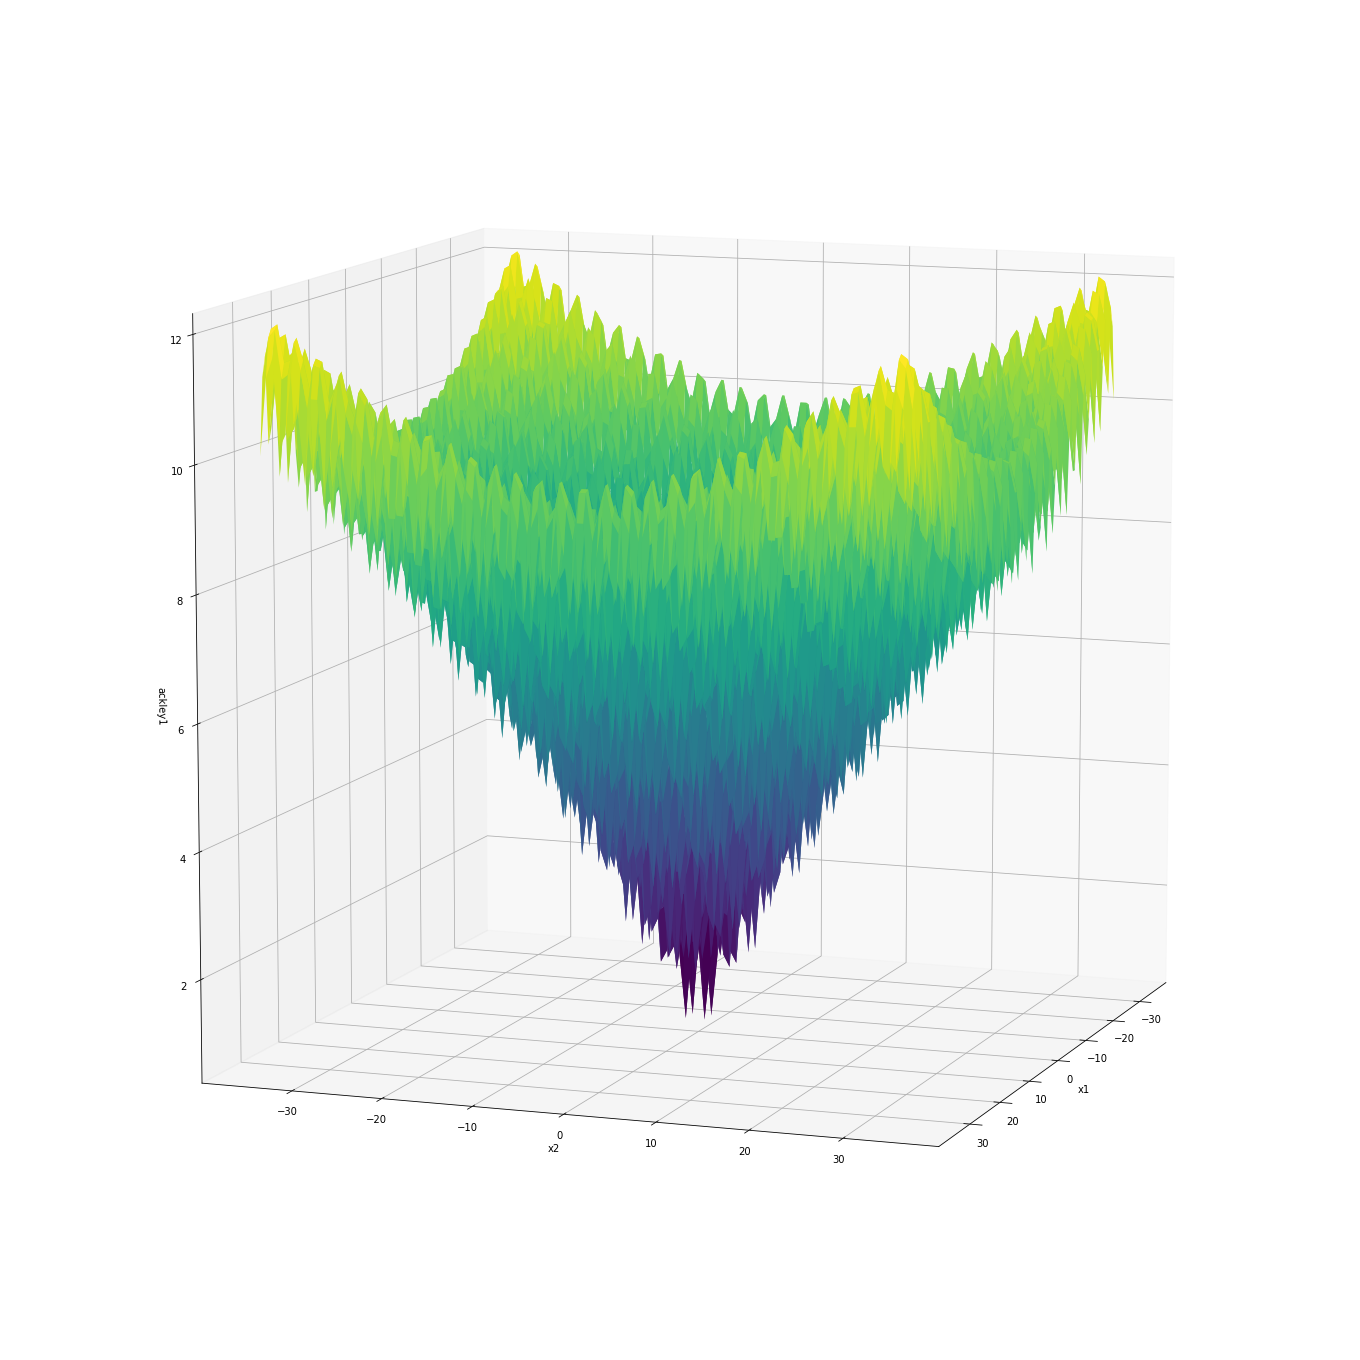

In [194]:
multiplot3d((x,y,z), 1)

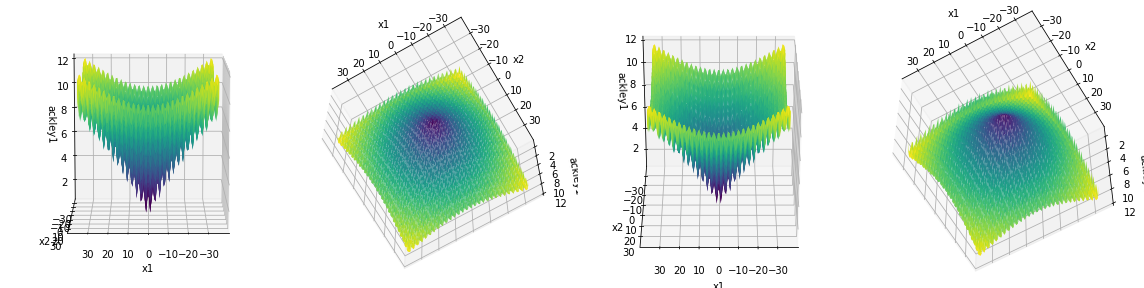

In [195]:
multiplot3d((x,y,z), 4)

- β) Με την διαδικασία που ακολουθήσαμε προηγουμένως για τη μη κλιμακούμενη συνάρτηση, βρείτε τον βέλτιστο γενετικό αλγόριθμο και τη βέλτιστη τιμή για το πρόβλημα. Θα αρχίσουμε αρχικοποιώντας τα `kargs` για τους γενετικούς τελεστές, και ορίζοντας τα βασικά `containers` του `deap`.

In [517]:
kargs_cxBlend = {
    "function" : tools.cxBlend,
    "args" : {
        "alpha" : [1,5]
    }
}

kargs_cxSimulatedBinary = {
    "function" : tools.cxSimulatedBinary,
    "args" : {
        "eta" : [0.2, 0.8]
    }
}

kargs_mutGaussian = {
    "function" : tools.mutGaussian,
    "args" : {
        "mu" : [0,20],
        "sigma" : [1,10],
        "indpb" : [0.5, 0.5]
    }
}

kargs_mutPolynomialBounded = {
    "function" : mutPolynomialBounded,
    "args" : {
        "eta" : [0.2, 0.2],
        "low" : [-5, -100],
        "up" : [5, 100],
        "indpb" : [0.5, 0.5]
    } 
}

kargs_selTournament = {
    "function" : tools.selTournament,
    "args" : {
        "tournsize" : [5, 30]
    }
}

strategy_ops = [eaMuCommaLambda_with_stats, eaMuPlusLambda_with_stats, eaSimple_with_stats]
mate_ops = [kargs_cxBlend, kargs_cxSimulatedBinary]
mutation_ops = [kargs_mutGaussian, kargs_mutPolynomialBounded]
selection_ops = [kargs_selTournament]

In [518]:
NUM_VARS = 2

creator.create( "min_fitness", base.Fitness , weights=(-1.0,))
creator.create( "individual_container", list , fitness= creator.min_fitness)
toolbox = base.Toolbox()
toolbox.register("init_value", np.random.uniform, -35, 35)
toolbox.register("individual", tools.initRepeat, creator.individual_container, toolbox.init_value, NUM_VARS)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def eval_ackley(ind):
    sum = ackley1(ind)
    
    return (sum,)

Θα ορίσουμε τα `kargs` που δέχεται ο `gridsearch` αλγόριθμος και θα τρέξουμε την πρώτη μας αναζήτηση του βέλτιστου συνδυασμού. 

In [519]:
ge_args = {
    "ge_with_stats" : None,
    "npop" : 100,
    "toolbox" : toolbox,
    "mu" : 100,
    "lambda_" : 200,
    "ngen" : 100,
    "cxpb" : 0.5,
    "mutpb" : 0.2,
    "rounds" : 5,
    "goal" : 0.0,
    "delta" : 0.005,
    "verbose" : False
}

Πριν ξεκινήσουμε θα πρέπει πρώτα να εγγράψουμε την συνάρτηση που θα εκτελεί το `evaluation` του fitness των γονίδιων. Το `fitness` value πλεόν των ατόμων δεν θα υπολογίζεται απλά με την τιμή που επιστρέφει η `Ackley1`, αλλά με επιπλέον περιορισμούς. Ο βασικός τρόπος για να επιβάλουμε περιορισμούς είναι να επιβάλουμε μια ποινή στην τιμή της καταλληλότητας στα άτομα που είναι εκτός των ορίων που έχουμε θέσει. 

----

Αρχικά ορίζουμε δύο συναρτήσεις, τη "feasible" που μας επιστρέφει True αν όλα τα $x_i$ είναι εντός του διαστήματος και False αλλιώς και την "distance" που μας ποσοτικοποιεί πόσο εκτός ορίων είναι ένα άτομο. Συγκεκριμένα επιλέγουμε η απόσταση να είναι το απόλυτο άθροισμα σε όλες τις διαστάσεις της απόστασης από το όριο. Θα μπορούσαμε να κάνουμε και άλλες επιλογές όπως πχ να χρησιμοποιήσουμε μια τετραγωνική συνάρτηση της απόστασης.

In [520]:
MIN_BOUND = -35.0
MAX_BOUND = 35.0

def feasible(indiv):
    for i in range (len(indiv)) :
        if (indiv [i] < MIN_BOUND) or (indiv [i] > MAX_BOUND):
            return False
    return True

def distance(indiv) :
    dist = 0.0
    for i in range (len(indiv)) :
        penalty = 0
        if ( indiv [i] < MIN_BOUND) : penalty = MIN_BOUND - indiv [i]
        if ( indiv [i] > MAX_BOUND) : penalty = indiv [i] - MAX_BOUND
        dist = dist + penalty
    return dist

Μια πολύ χρήσιμη μέθοδος που διαθέτει η Python και η DEAP είναι η διακόσμηση συναρτήσεων μέσω διακοσμητών (decorators). Πρόκειται για τη δυνατότητα να τροποποιούμε τη συμπεριφορά μιας συνάρτησης χωρίς να μεταβάλουμε τον κώδικά της αλλά επιτυγχάνοντάς το μέσω μιας άλλης συνάρτησης (του decorator). Με την παρακάτω εντολή μπορούμε τροποποιήσουμε τη συνάρτηση καταλληλότητας `eval_ackley` με την builtin `DeltaPenality`. 

---

Το ζήτημα που ανακύπτει είναι πως θα βρούμε την κατάλληλη τιμή για την σταθερά Δ. Θα μπορούσαμε να πούμε ότι πρόκειται για την τελευταία `valid fitness` τιμή των ατόμων. Κοιτώντας την γραφική παράσταση του πρώτου ερωτήματος παρατηρούμε ότι η τιμή αυτή ειναι 12. Αυτό δεν σημαίνει ότι η σταθέρα θα είναι πάντα ίδια για όλες τις διαστάσεις αλλά θα αυξάνεται γραμμικά καθώς αυξάνονται και οι διαστάσεις. Αν λοιπον σε 2 διαστάστεις έχουμε τιμή 12, τότε σε n θα είναι $6* n$.

In [521]:
toolbox.register("evaluate", eval_ackley)
toolbox.decorate("evaluate", tools.DeltaPenality (feasible, 12, distance))

Η DeltaPenality ή ποινή-Δ απαιτεί τουλάχιστον δύο ορίσματα. Το πρώτο πρέπει να επιστρέφει αν ένα άτομο είναι έγκυρο ή όχι, σύμφωνα με τα όρια που έχουμε θέσει. Εμείς θα χρησιμοποιήσουμε τη "feasible" που ορίσαμε γι' αυτό το λόγο. Το δεύτερο όρισμα είναι η σταθερά Δ, δηλαδή η σταθερή ποινή που θα προστεθεί (σε πρόβλημα ελαχιστοποίησης) ή αφαιρεθεί (σε πρόβλημα μεγιστοποίησης) στην τιμή καταλληλότητας ενός ατόμου που είναι εκτός των ορίων που θέλουμε. Ο τρίτος όρος είναι μια επιπλέον ποινή που μπορεί να εφαρμοστεί και που συνήθως την ορίζουμε να είναι ανάλογη του κατά πόσο είναι εκτός ορίων ένα άτομο. Συνολικά δηλαδή θα έχουμε: 
$$f_i^\mathrm{penalty}(\mathbf{x}) = \Delta - w_i d_i(\mathbf{x})$$

In [510]:
ametrics = gridsearch(ge_args, strategy_ops, mate_ops, mutation_ops, selection_ops, verbose=True)

['cxBlendLow,mutGaussianLow,selTournamentLow', 'eaMuCommaLambda 200 100 200', 5, 0.003483672491897227, 2407.8, 16.6, 14091.4, 4.440892098500626e-16, 0.7899487972259521]
['cxBlendLow,mutGaussianLow,selTournamentHigh', 'eaMuCommaLambda 200 100 200', 5, 0.0033530452903950624, 1450.0, 9.6, 14147.2, 2.1299117153450454e-05, 1.0575481414794923]
['cxBlendLow,mutGaussianHigh,selTournamentLow', 'eaMuCommaLambda 200 100 200', 4, 0.0011304497097888166, 4695.25, 33.0, 14094.8, 0.0051018621214088174, 0.8807125568389893]
['cxBlendLow,mutGaussianHigh,selTournamentHigh', 'eaMuCommaLambda 200 100 200', 3, 0.0020911287246960044, 2184.6666666666665, 15.0, 14145.4, 0.0896987604976954, 1.0619815826416015]
['cxBlendLow,mutPolynomialBoundedLow,selTournamentLow', 'eaMuCommaLambda 200 100 200', 4, 0.002900159352440479, 2139.5, 14.5, 14089.2, 0.011481030834430061, 0.7376937866210938]
['cxBlendLow,mutPolynomialBoundedLow,selTournamentHigh', 'eaMuCommaLambda 200 100 200', 5, 0.0036597772611938416, 3979.8, 28.0, 14

In [515]:
columns = ['operators', 'strategy', 'successes', 's.avg.min', 's.avg.evals', 's.avg.gens', 'avg.evals', 'avg.min', 'avg.time']
aframe1 = report(ametrics, columns_names=columns)
aframe1.sort_values(by=['successes','avg.min'], ascending=False)


,operators,strategy,successes,s.avg.min,s.avg.evals,s.avg.gens,avg.evals,avg.min,avg.time
53,"cxSimulatedBinaryLow,mutPolynomialBoundedLow,selTournamentHigh",eaMuPlusLambda 200 100 200,5,0.002272,6811.2,47.8,14109.6,7.619486e-04,1.092932
5,"cxBlendLow,mutPolynomialBoundedLow,selTournamentHigh",eaMuCommaLambda 200 100 200,5,0.003660,3979.8,28.0,14028.2,5.644641e-04,1.040571
43,"cxBlendHigh,mutGaussianHigh,selTournamentHigh",eaMuPlusLambda 200 100 200,5,0.002070,6606.4,46.4,14110.8,5.348798e-04,1.076607
89,"cxSimulatedBinaryHigh,mutGaussianLow,selTournamentHigh",eaSimple 200,5,0.003036,1225.8,19.0,6034.0,2.325456e-04,0.739421
65,"cxBlendLow,mutGaussianLow,selTournamentHigh",eaSimple 200,5,0.003325,770.2,11.2,6105.2,1.677778e-04,0.727254
81,"cxSimulatedBinaryLow,mutGaussianLow,selTournamentHigh",eaSimple 200,5,0.001591,1588.6,24.6,6107.4,7.164929e-05,0.672206
1,"cxBlendLow,mutGaussianLow,selTournamentHigh",eaMuCommaLambda 200 100 200,5,0.003353,1450.0,9.6,14147.2,2.129912e-05,1.057548
73,"cxBlendHigh,mutGaussianLow,selTournamentHigh",eaSimple 200,5,0.002754,1493.2,22.8,6080.2,1.159221e-05,0.644666
33,"cxBlendLow,mutGaussianLow,selTournamentHigh",eaMuPlusLambda 200 100 200,5,0.003060,1604.8,10.8,14088.8,5.974547e-06,1.074298
9,"cxBlendHigh,mutGaussianLow,selTournamentHigh",eaMuCommaLambda 200 100 200,5,0.002899,2684.2,18.4,14094.8,9.402600e-07,1.049542


Λόγω του μικρού αριθμού γύρων αλλά και της καλής συμπεριφοράς της συνάρτησης μας, πολλά απο τα αποτελέσματα σημειώνουν πλήρη επιτυχία (5/5). Παρόλα αυτά πολλά απο τα αποτελέσματα είναι ψευδό-σωστά, αν παρατηρήσουμε τις στήλες των σχετικών κριτηρίων. Μπορεί στην στήλη των `successes` να πετυχαίνουμε 5/5, οι περισσότερες όμως απο τις τιμές της `s.avg.min` εμφανίζουν μια σχετική απόκλιση απο το απόλυτο 0.0, και αυτό βέβαια έχει να κάνει τόσο με τον πληθυσμό όσο και απο τον αριθμό των γενεών. Εφόσον ως στόχο έχουμε να εντοπίσουμε τον βέλτιστο συνδυασμό γενετικών τελεστών και αλγόριθμου, το επόμενο μας βήμα θα είναι να μειώσουμε το `delta` και να εκτελέσουμε ένα νέο `gridsearch`.

In [542]:
ge_args = {
    "ge_with_stats" : None,
    "npop" : 100,
    "toolbox" : toolbox,
    "mu" : 100,
    "lambda_" : 200,
    "ngen" : 100,
    "cxpb" : 0.7,
    "mutpb" : 0.2,
    "rounds" : 5,
    "goal" : 0.0,
    "delta" : 0.00000000005,
    "verbose" : False
}

strategy_ops = [eaSimple_with_stats, eaMuCommaLambda_with_stats, eaMuPlusLambda_with_stats]
mate_ops = [kargs_cxBlend, kargs_cxSimulatedBinary]
mutation_ops = [kargs_mutGaussian, kargs_mutPolynomialBounded]
selection_ops = [kargs_selTournament]

In [537]:
ametrics2 = gridsearch(ge_args, strategy_ops, mate_ops, mutation_ops, selection_ops, verbose=True)

['cxBlendLow,mutGaussianLow,selTournamentLow', 'eaSimple 100', 5, 3.6438496664459307e-11, 4188.2, 53.8, 7675.0, 4.440892098500626e-16, 0.3481762886047363]
['cxBlendLow,mutGaussianLow,selTournamentHigh', 'eaSimple 100', 1, 1.481526012980794e-11, 4185.0, 54.0, 7677.6, 2.413863843919728e-07, 0.6192619323730468]
['cxBlendLow,mutGaussianHigh,selTournamentLow', 'eaSimple 100', 4, 3.396793957222144e-11, 4210.25, 53.75, 7744.4, 0.05602544064608468, 0.31205043792724607]
['cxBlendLow,mutGaussianHigh,selTournamentHigh', 'eaSimple 100', 0, None, None, None, 7700.8, 0.24892562794686174, 0.6226191997528077]
['cxBlendLow,mutPolynomialBoundedLow,selTournamentLow', 'eaSimple 100', 3, 3.6164700863613085e-11, 3844.3333333333335, 49.0, 7746.4, 0.03909555395659838, 0.3145275115966797]
['cxBlendLow,mutPolynomialBoundedLow,selTournamentHigh', 'eaSimple 100', 0, None, None, None, 7726.4, 0.11958329674583767, 0.6167078495025635]
['cxBlendLow,mutPolynomialBoundedHigh,selTournamentLow', 'eaSimple 100', 4, 2.6662

In [539]:
columns = ['operators', 'strategy', 'successes', 's.avg.min', 's.avg.evals', 's.avg.gens', 'avg.evals', 'avg.min', 'avg.time']
aframe2 = report(ametrics2, columns_names=columns)
aframe2.sort_values(by=['successes', 'avg.min'], ascending=False)


,operators,strategy,successes,s.avg.min,s.avg.evals,s.avg.gens,avg.evals,avg.min,avg.time
72,"cxBlendHigh,mutGaussianLow,selTournamentLow",eaMuPlusLambda 100 100 200,5,2.387610e-11,15703.40,86.60,18105.2,4.528733e-12,1.232981
61,"cxSimulatedBinaryHigh,mutPolynomialBoundedLow,selTournamentHigh",eaMuCommaLambda 100 100 200,5,3.005569e-11,7654.80,42.00,18089.8,2.036593e-13,1.463756
24,"cxSimulatedBinaryHigh,mutGaussianLow,selTournamentLow",eaSimple 100,5,3.558727e-11,4766.20,61.20,7729.4,1.154632e-15,0.323050
84,"cxSimulatedBinaryLow,mutPolynomialBoundedLow,selTournamentLow",eaMuPlusLambda 100 100 200,5,3.112222e-11,9861.00,54.20,18088.4,1.154632e-15,1.442451
89,"cxSimulatedBinaryHigh,mutGaussianLow,selTournamentHigh",eaMuPlusLambda 100 100 200,5,3.318279e-11,7781.00,42.60,18111.2,1.154632e-15,1.530954
0,"cxBlendLow,mutGaussianLow,selTournamentLow",eaSimple 100,5,3.643850e-11,4188.20,53.80,7675.0,4.440892e-16,0.348176
16,"cxSimulatedBinaryLow,mutGaussianLow,selTournamentLow",eaSimple 100,5,3.300729e-11,4198.80,54.20,7678.2,4.440892e-16,0.315208
32,"cxBlendLow,mutGaussianLow,selTournamentLow",eaMuCommaLambda 100 100 200,5,2.594591e-11,8600.00,47.20,18116.0,4.440892e-16,0.925060
38,"cxBlendLow,mutPolynomialBoundedHigh,selTournamentLow",eaMuCommaLambda 100 100 200,5,2.998890e-11,10243.00,56.40,18071.4,4.440892e-16,1.111194
48,"cxSimulatedBinaryLow,mutGaussianLow,selTournamentLow",eaMuCommaLambda 100 100 200,5,2.505987e-11,7948.40,43.60,18058.0,4.440892e-16,1.129851


Ορισμένοι καλοί συνδυασμοί έχουν ήδη αρχίσει να κάνουν αισθητή την παρουσία τους, κάτι που μας επιτρέπει εν τέλει να αρχίσουμε την διαδικασία αποκλισμού γενετικών τελεστών. Το επόμενο μας βήμα θα είναι να αφαιρέσουμε αυτούς τους συνδυασμούς και να αρχίσουμε ξανά την αναζήτηση μας, μικραίνοντας ακόμη και κατά 3 τάξης μεγέθους το `delta`. Ωστόσο κρίνεται σκόπιμο να αναφέρουμε τις παρατηρήσεις που μας οδήγησαν σε αυτές τις επιλογές.

- cxBlendHigh οδηγεί κατά κύριο λίγο σε κακιές εποδόσεις.
- Οι High τελεστές μετάλλαξης και επιλογής "ακυρώνουν" σε συνάρτηση με το Δ penalty αρκετούς απογόνους.
- Low συνδυασμοί τελεστών ανεξαρτήτα του γενετικού αλγόριθμου σημειώνουν αρκετά καλή επίδοση.

Ο πρώτος και τρίτος λόγος δεν χρειάζονται κάποια περαιτέρω δικαιολόγηση για να πιστεί κανείς, αρκεί απλά να κοιτάξει τον πίνακα των αποτελεσμάτων. Όσο για την δεύτερη παρατήρηση μπορούμε μια ευκολία να παραθέσουμε μία βάσιμη αιτία που δικαιολογεί αυτήν την συμπεριφορά. Υψηλός τελεστής μετάλλαξης σημαίνει απαραίτητα και μεγάλη αλλαγή στο γενετικό υλικό, άρα και μεγαλύτερη πιθανότητα πολλοί απόγονοι να βγουν εκτός ορίων και επομένως να λάβουν πολύ μεγάλο penalty.

In [546]:
kargs_cxBlend = {
    "function" : tools.cxBlend,
    "args" : {
        "alpha" : [1]
    }
}

kargs_cxSimulatedBinary = {
    "function" : tools.cxSimulatedBinary,
    "args" : {
        "eta" : [0.2]
    }
}

kargs_mutGaussian = {
    "function" : tools.mutGaussian,
    "args" : {
        "mu" : [0],
        "sigma" : [1],
        "indpb" : [0.5]
    }
}

kargs_mutPolynomialBounded = {
    "function" : mutPolynomialBounded,
    "args" : {
        "eta" : [0.2],
        "low" : [-5],
        "up" : [5],
        "indpb" : [0.5]
    } 
}

kargs_selTournament = {
    "function" : tools.selTournament,
    "args" : {
        "tournsize" : [5]
    }
}

ge_args = {
    "ge_with_stats" : None,
    "npop" : 100,
    "toolbox" : toolbox,
    "mu" : 100,
    "lambda_" : 200,
    "ngen" : 100,
    "cxpb" : 0.7,
    "mutpb" : 0.2,
    "rounds" : 5,
    "goal" : 0.0,
    "delta" : 0.000000000005,
    "verbose" : False
}

In [544]:
ametrics3 = gridsearch(ge_args, strategy_ops, mate_ops, mutation_ops, selection_ops, verbose=True)

['cxBlendLow,mutGaussianLow,selTournamentLow', 'eaSimple 100', 5, 2.284128441942812e-12, 4015.2, 51.8, 7690.6, 4.440892098500626e-16, 0.34786186218261717]
['cxBlendLow,mutPolynomialBoundedLow,selTournamentLow', 'eaSimple 100', 4, 2.1747048606357566e-12, 4403.5, 56.5, 7698.6, 0.05602544064608468, 0.5415234565734863]
['cxSimulatedBinaryLow,mutGaussianLow,selTournamentLow', 'eaSimple 100', 5, 2.7147173398134328e-12, 4321.6, 55.6, 7689.0, 4.440892098500626e-16, 0.380991268157959]
['cxSimulatedBinaryLow,mutPolynomialBoundedLow,selTournamentLow', 'eaSimple 100', 2, 1.7714718580918998e-12, 5647.5, 73.0, 7671.6, 0.11279744357011028, 0.4231136322021484]
['cxBlendLow,mutGaussianLow,selTournamentLow', 'eaMuCommaLambda 100 100 200', 5, 2.367261942026744e-12, 9631.8, 53.0, 18101.2, 4.440892098500626e-16, 1.1760366439819336]
['cxBlendLow,mutPolynomialBoundedLow,selTournamentLow', 'eaMuCommaLambda 100 100 200', 2, 4.203304371230843e-12, 10544.5, 58.0, 18106.6, 0.19111290262444572, 0.9722096443176269]

In [545]:
aframe3 = report(ametrics3, columns_names=columns)
aframe3.sort_values(by=['successes', 'avg.min'], ascending=False)

,operators,strategy,successes,s.avg.min,s.avg.evals,s.avg.gens,avg.evals,avg.min,avg.time
0,"cxBlendLow,mutGaussianLow,selTournamentLow",eaSimple 100,5,2.284128e-12,4015.2,51.8,7690.6,4.440892e-16,0.347862
2,"cxSimulatedBinaryLow,mutGaussianLow,selTournamentLow",eaSimple 100,5,2.714717e-12,4321.6,55.6,7689.0,4.440892e-16,0.380991
4,"cxBlendLow,mutGaussianLow,selTournamentLow",eaMuCommaLambda 100 100 200,5,2.367262e-12,9631.8,53.0,18101.2,4.440892e-16,1.176037
6,"cxSimulatedBinaryLow,mutGaussianLow,selTournamentLow",eaMuCommaLambda 100 100 200,5,3.634870e-12,8793.2,48.4,18074.2,4.440892e-16,1.121696
7,"cxSimulatedBinaryLow,mutPolynomialBoundedLow,selTournamentLow",eaMuCommaLambda 100 100 200,5,2.998934e-12,9576.6,52.8,18082.4,4.440892e-16,1.259825
8,"cxBlendLow,mutGaussianLow,selTournamentLow",eaMuPlusLambda 100 100 200,5,2.478107e-12,9331.6,51.2,18107.8,4.440892e-16,1.124842
9,"cxBlendLow,mutPolynomialBoundedLow,selTournamentLow",eaMuPlusLambda 100 100 200,5,2.034017e-12,9244.2,50.8,18111.4,4.440892e-16,0.991274
10,"cxSimulatedBinaryLow,mutGaussianLow,selTournamentLow",eaMuPlusLambda 100 100 200,5,3.234124e-12,8965.0,49.2,18117.6,4.440892e-16,1.000881
11,"cxSimulatedBinaryLow,mutPolynomialBoundedLow,selTournamentLow",eaMuPlusLambda 100 100 200,5,2.727507e-12,9148.8,50.4,18071.2,4.440892e-16,1.014383
1,"cxBlendLow,mutPolynomialBoundedLow,selTournamentLow",eaSimple 100,4,2.174705e-12,4403.5,56.5,7698.6,5.602544e-02,0.541523


Παρόλο που για όλους του γενετικούς αλγόριθμους βρέθηκαν επιτυχημένοι συνδυασμοί τελεστών, θα πρέπει έναν απο αυτούς να διαλέξουμε για την τελική μας επιλογή. Η τελική επιλογή θα κριθεί τόσο από τα απόλυτα όσο και απο τα σχετικά κριτήρια. Θα ξεκινήσουμε βέβαια με τα πρώτα που αποτελούν και τα σημαντικότερα για την αξιολόγηση των γενετικών αλγορίθμων. Αν εξαιρέσουμε τις `avg.evals, avg.time` όπου εκεί εμφανίζεται έντονη διαφορά μεταξύ των αποτελεσμάτων, η `avg.time` που αποτελεί το πιο βασικό κριτήριο, έχει ακριβώς την ίδια τιμή σε όλα. Με τον χαρακτηρισμό "βασικό κριτήριο" δεν σημαίνει ότι οι υπόλοιπες είναι ήσσονος σημασίας αλλά οι αποκλίσεις που παρατηρούμε οφείλονται κυρίως στον τρόπο λειτουργίας των δύο αλγορίθμων. Η επιλογή μας θα καθοριστεί εν τέλει απο τα σχετικά κριτήρια. Όπως και στην περίπτωση των `avg.evals, avg.min` έτσι και οι `s.avg.evals, s.avg.min` οι τιμές είναι πρακτικά ίδιες. Η επιλογή μας θα καθοριστεί εν τέλει απο τα `s.avg.gens`. Από όλους τους συνδυασμούς εκείνος που σημειώσε τον μικρότερο αριθμό από γενιές για να φτάσει στην λύση είναι:

$$cxSimulatedBinaryLow,\ mutGaussianLow,\ selTournamentLow,\ eaMuPlusLambda\ 100\ 100\ 200$$

In [551]:
ge_args = {
    "ge_with_stats" : None,
    "npop" : 100,
    "toolbox" : toolbox,
    "mu" : 100,
    "lambda_" : 200,
    "ngen" : 100,
    "cxpb" : 0.7,
    "mutpb" : 0.2,
    "rounds" : 10,
    "goal" : 0.0,
    "delta" : 0.0000000000005,
    "verbose" : False
}

strategy_ops = [eaMuPlusLambda_with_stats]
mate_ops = [kargs_cxSimulatedBinary]
mutation_ops = [kargs_mutGaussian]
selection_ops = [kargs_selTournament]

In [552]:
ametrics4 = gridsearch(ge_args, strategy_ops, mate_ops, mutation_ops, selection_ops, verbose=True)

['cxSimulatedBinaryLow,mutGaussianLow,selTournamentLow', 'eaMuPlusLambda 100 100 200', 10, 2.8252955530660986e-13, 9049.9, 49.8, 18092.1, 4.440892098500626e-16, 0.9671252727508545]


In [553]:
aframe4 = report(ametrics4, columns_names=columns)
aframe4.sort_values(by=['successes', 'avg.min'], ascending=False)

,operators,strategy,successes,s.avg.min,s.avg.evals,s.avg.gens,avg.evals,avg.min,avg.time
0,"cxSimulatedBinaryLow,mutGaussianLow,selTournamentLow",eaMuPlusLambda 100 100 200,10,2.825296e-13,9049.9,49.8,18092.1,4.440892e-16,0.967125


### Για D=1, 10, 20, 40 και μεγαλύτερες διαστάσεις

Για τον βέλτιστο αλγόριθμο (που βρήκαμε για τις 2 διαστάσεις) και για διαφορετικές τιμές/τάξεις μεγέθους D=1, 10, 20, 40 ή και περισσότερων διαστάσεων του πεδίου ορισμού (σταθερά MAX_GENS και MAX_ROUNDS>=10) θα τυπώσουμε πίνακα με: **αριθμό διαστάσεων**, **αριθμό επιτυχιών**, **μέσο ολικό ελάχιστο**, **μέσο αριθμό αποτιμήσεων** και **μέσο χρόνο**.

Ευτυχώς το διαδικαστικό της υπόθεσης δεν θα μας δυσκολέψει. Έχουμε ήδη απο προηγούμενα ερωτήμα αναπτύξει ένα μεγάλο πλήθος παραμετροποιήσημων συναρτήσεων που και σε αυτή την περίπτωση λειτουργούν αποτελεσματικά. Ένας απλός wrapper, σχεδόν ίδιος με τον `prod_grisearch` θα δέχεται ως είσοδο την λίστα με την διαστάσεις και αφού λάβει τα αποτελέσματα από την evolution_with_stats, θα κρατάει εκείνα που ζητά η εκφώνηση για να εμφανίσει. Παρεά με την `dim_gridsearch` δημιουργήσαμε και την `new_toolbox` η οποία το μόνο που κάνει είναι να δημιουργεί κανούργια toolbox με βάση τις διαστάσεις που θέλουμε να ελέγχουμε κάθε φορά.

In [593]:
def dim_gridsearch(ge_args, dims, verbose=False):
    metrics = []
    for dim in dims:
        ntoolbox = new_toolbox(dim)
        ge_args["toolbox"] = ntoolbox
        
        lmetrics = listify(evolution_with_stats(**ge_args))
        ret = [dim, lmetrics[0], *lmetrics[-3:]]

        if verbose:
            print(ret)

        metrics.append(ret)
    return metrics

def new_toolbox(dim):
    toolbox = base.Toolbox()
    toolbox.register("init_value", np.random.uniform, -35, 35)
    toolbox.register("individual", tools.initRepeat, creator.individual_container, toolbox.init_value, dim)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate", eval_ackley)
    toolbox.decorate("evaluate", tools.DeltaPenality (feasible, 6 * dim, distance))
    
    toolbox.register("mate", tools.cxSimulatedBinary, eta=0.2)
    toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=1.0, indpb=0.5)
    toolbox.register("select", tools.selTournament, tournsize=5)
    
    return toolbox

In [597]:
ge_args = {
    "ge_with_stats" : eaMuPlusLambda_with_stats,
    "npop" : 100,
    "toolbox" : None,
    "mu" : 100,
    "lambda_" : 200,
    "ngen" : 100,
    "cxpb" : 0.7,
    "mutpb" : 0.2,
    "rounds" : 15,
    "goal" : 0.0,
    "delta" : 0.000000000005,
    "verbose" : False
}

In [594]:
dims = [1, 10, 20, 40]

dimf = dim_gridsearch(ge_args, dims, verbose=True)

In [579]:
columns = ['dim', 'successes', 'avg.evals', 'avg.min', 'avg.time']
dimframe = report(dimf, columns_names=columns)
dimframe.sort_values(by=['successes', 'avg.min'], ascending=False)


,dim,successes,avg.evals,avg.min,avg.time
0,1,15,18090.800000,4.440892e-16,0.904065
3,40,0,18090.800000,4.544392e+00,2.762170
2,20,0,18108.200000,2.593092e+00,1.917211
1,10,0,18078.533333,9.116647e-01,1.374228


Ενώ τόσο στη μία όσο και στις δύο διαστάσεις ο γενετικός αλγόριθμος σημειώνει πλήρης επιτυχία, όσο οι διαστάσεις μεγαλώνουν το φαινόμενο αυτό σταματά. Ωστόσο το σημαντικό μέγεθος που πρέπει να μας αποσχολεί δεν είναι οι επιτυχίες αλλά το `avg.min`, καθώς μια προσεγγιστικά καλή λύση μπορεί να μην θεωρείται επιτυχημένη όταν το `delta` είναι αρκετά μεγαλό. Αν λοιπόν το ξεχάσουμε και επικεντρωθούμε στην βασική μας μετρική τα πράγματα έχουν ως εξής. Οι εξελικτικοί αλγόριθμοι όπως γνωρίζουμε ξεκινάν από ένα βασικό πληθυσμό ατόμων, τα όποια από γενιά σε γενία, περνάνε απο έναν κύκλο διασταυρώσεων και μεταλλάξεων παράγοντας νέους πιθανόν καλύτερους απογόνους. Μέσω της φυσικής επιλογής, εκείνη που έχουν περισσότερες πιθανότητες επιβιώσης, συνεχίζουν δημιουργώντας νέους απογόνους. Μπορεί ωστόσο οι συνθήκες του κόσμου (διαστάσεις) να αλλάζουν ραγδαία και ο πληθυσμός να μην αρκεί ή να μην προλάβει ποτέ να προσαρμοστεί, μέχρι εν τέλει να εκλείψει. 

---

Ο λόγος που κάναμε αυτό τον παραλληλισμό είναι γιατί θέλαμε με έναν πιο έμμεσο τρόπο να αποκωδικοποιήσουμε το πρόβλημα και να το περάσουμε μέσα από ένα πρίσμα πιο ανθρώπινο και επιστημονικό. Όπως οι συνθήκες αλλάζουν, έτσι και οι διαστάσεις, απαιτείται μεγαλύτερος πληθυσμός άρα περισσότερες γενιές ώστε να "προλάβει" προσαρμοστεί και εν τέλει να επιδιώσει. Έτσι, ακόμα και όταν παράγονται άκυρα άτομα κατά την διαδικασία της διασταύρωσης, πολύ περισσότερο μάλιστα κατά την διαδικασία της μετάλλαξης, θα είναι πιο πιθανό κατά την φάση της επιλογής να βρεθούν εύκολα άτομα με καλή τιμή καταλληλότητας.


### Βελτιστοποίηση σε μεγάλες διαστάσεις


Με τα παραπάνω κατά νου, επιχειρούμε αυξάνοντας το μέγεθος του πληθυσμού και των γενεών, να παίρνουμε όλο και καλύτερα αποτελέσματα. Ωστόσο πειδή ο γενετικός μας αλγόριθμος είναι τύπου `mu,lambda` πρέπει ανάλογα με τον αριθμό του πληθυσμού να αυξάνουμε και αυτά τα μεγέθη. Σε πρώτο βήμα θα τρέξουμε ξάνα και για τις τέσσερις διαστάσεις για να βεβαιωθούμε ότι η ιδέα μας αποδεικνύεται σωστή

In [595]:
ge_args["npop"] = 400
ge_args["ngen"] = 400
ge_args["mu"] = 300
ge_args["lambda_"] = 500

In [ ]:
dimf2 = dim_gridsearch(ge_args, dims)

In [629]:
dimframe2 = report(dimf2, columns_names=columns)
dimframe2.sort_values(by=['successes', 'avg.min'], ascending=False)

,dim,successes,avg.evals,avg.min,avg.time
0,1,15,180422.800000,4.440892e-16,9.972107
3,40,0,180454.466667,2.047179e+00,28.991038
2,20,0,180355.933333,7.476570e-01,20.384083
1,10,0,180411.533333,3.955460e-02,14.672214


Έχοντας πλέον σταθερή διάσταση 40, θα συνεχίσουμε στην ίδια λογική, προσπαθώντας να παίρνουμε όλο και καλύτερα αποτελέσματα. 

In [598]:
ge_args["npop"] = 800
ge_args["ngen"] = 400
ge_args["mu"] = 300
ge_args["lambda_"] = 500

dims = [40]

In [600]:
dimf3 = dim_gridsearch(ge_args, dims, verbose=True)

[40, 0, 180886.93333333332, 1.970354405556624, 34.53201745351156]


In [601]:
ge_args["npop"] = 800
ge_args["ngen"] = 800
ge_args["mu"] = 300
ge_args["lambda_"] = 500

In [602]:
dimf4 = dim_gridsearch(ge_args, dims, verbose=True)

[40, 0, 360785.93333333335, 0.836490546541513, 66.7170267422994]


In [605]:
ge_args["npop"] = 1200
ge_args["ngen"] = 800
ge_args["mu"] = 300
ge_args["lambda_"] = 500

In [606]:
dimf5 = dim_gridsearch(ge_args, dims, verbose=True)

[40, 0, 361152.5333333333, 0.7794275311025456, 66.30950926144918]


In [634]:
dim_metris = [dimf3[0], dimf4[0], dimf5[0]]
report(dim_metris, columns_names=columns)

,dim,successes,avg.evals,avg.min,avg.time
0,40,0,180886.933333,1.970354,34.532017
1,40,0,360785.933333,0.836491,66.717027
2,40,0,361152.533333,0.779428,66.309509


Πράγματι, όπως βλέπουμε στον πίνακα που ακολουθεί, η μέση τιμή `avg.min` των καλύτερων εκτιμήσεων μειώνεται όλο και περισσότερο, προσεγγίζοντας όλο και καλύτερα την πραγματική τιμή 0. Παρατηρούμε ότι στην τελευταία μας δοκιμή παρόλο την αύξηση του πληθυσμού και των γενεών μικρότερη βελτίωση συγκριτική με την προηγούμενη. Δεν θα έπρεπε ωστόσο να μας παραξενέυει, καθώς δεν θα μπορούσαμε να περιμένουμε το σύστημα να βελτιστοποιείται συνέχεια και με τον ίδιο ρυθμό.


---- 

Τέλος το μόνο που μένει είναι να βρούμε μια νέα -σταθερή- διάσταση, πιθανότατα μικρότερη από την προηγούμενη και ένα `delta` που να σας δίνουν 35% - 50% επιτυχίες. Αυτό μπορούμε να το επιτύχουμε μόνο εμπειρικά, έχοντας στο μυαλό μας πως προφανώς το `delta` θα πρέπει να μεγαλώνει όσο αυξάνει η διαστατικότητα. Ύστερα απο **αρκετές** δοκιμές βρήκαμε τον συνδυασμό των παραμέτρων που το πετυχαίνει.

In [647]:
ge_args["npop"] = 1200
ge_args["ngen"] = 800
ge_args["mu"] = 300
ge_args["lambda_"] = 500
ge_args["delta"] = 0.5

In [648]:
final1 = dim_gridsearch(ge_args, [30], verbose=True)

[30, 7, 361175.26666666666, 0.5943022408587609, 62.28006091117859]


Μειώνοντας το `delta` στο μισό (σε 0.25) έχουμε την δυνατότητα να υπερδιπλασιάσουμε το ποσοστό των επιτυχιών. Ωστόσο για να συμβεί αυτό έπρεπε να αυξήσουμε των αριθμό του πληθυσμού και των γενεών κατά ένα κατά τον μισό του παράγοντα αλλαγής του `delta`.

In [ ]:
ge_args["npop"] = 1600
ge_args["ngen"] = 100
ge_args["mu"] = 300
ge_args["lambda_"] = 500
ge_args["delta"] = 0.25

In [661]:
final2 =  dim_gridsearch(ge_args, [30], verbose=True)

[30, 13, 361206.5333333333, 0.092216172625731, 68.1421768506368]

Δυστυχώς αν ξαναμειώσουμε το `delta` στο μισό με την ίδια αλλαγή στα άλλα 2 μεγέθη, το αποτέλεσμα δεν θα είναι το ίδιο (δεν γίνεται και πρακτικά μιας και το μέγιστο είναι 50). Θα πρέπει να διπλασιάσουμε σχεδόν και τα άλλα δύο μεγέθη για να καταφέρουμε και τον διπλασιασμό των επιτυχίων.